# **Aplicaciones en Tecnologías del Lenguaje - Práctica Temas 1 y 2**
## Notebook 3 - DL Approaches
### Student: Alvarez Lacasa, Lucas Alfredo

In this notebook, we will focus on the use of Transformers and contextual models for Natural Language Processing. In this case, we will apply them to the binary classification task that we have been working on.

More specifically, we will address topics very similar to those in the previous notebook, but now exploring more complex and powerful models.

💡 Some parts of this notebook were run locally in my laptop and some others in Google Colab, as I needed GPU acceleration.

# Global Imports

Imports are declared on this first section of the notebook.

In [ ]:
# Make only one GPU available for Pytorch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import abc
import bz2
import csv
import datetime
import gc
import gzip
import itertools
import re
from dataclasses import dataclass, field
from enum import StrEnum
from typing import TypeAlias, Iterator

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from setfit import SetFitModel, Trainer, TrainingArguments, sample_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from transformers import EarlyStoppingCallback
from transformers import PreTrainedModel, AutoModelForSequenceClassification, PreTrainedTokenizer, \
    ZeroShotClassificationPipeline

In [2]:
# Print available GPUs
# Had to do this trick when training on the multi-gpu machine in order to make it see only one GPU.
print(torch.cuda.device_count())

1


# Functions and Auxiliary classes

I will define a set of utility functions and classes to avoid code duplication, making the notebook more maintainable and easier to re-execute. I believe this is generally a good practice, especially in longer notebooks, to isolate code execution in a way that reduces the likelihood of errors.

The vast majority of utility functions and classes (regardless of which section of the index they belong to) will be listed here for the sake of simplicity and to make it easier to reload the notebook during development.

In [11]:
"""
=========================
Route resolution class

EDIT THIS CLASS depending on where you will be running this notebook!
=========================
"""

COLAB_BASE_MOUNT_POINT: str = "/content/drive"


@dataclass
class RouteConfig:
    notebook_name: str
    run_in_colab: bool = False
    # TODO: Change this to your base Colab path!!! =========>
    colab_base_mount_point: str = COLAB_BASE_MOUNT_POINT
    colab_practice_base_dir: str = f"{COLAB_BASE_MOUNT_POINT}/My Drive/UNED/master_nlp/AplicacionesNLP/Tema_2/challenge"
    # local_practice_base_dir: str = "/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge"
    local_practice_base_dir: str = "/tmp/pycharm_project_557/Tema_2/challenge"
    # ======================================================>
    exp_output_rel_folder_path: str = "experiment_output"


class RouteResolver:
    """ This object abstracts the retrieval of the files used in this notebook by only editing the RouteConfig class received """

    def __init__(self, route_config: RouteConfig) -> None:
        if route_config.run_in_colab:
            # Import and mount into the base mount path for Google Colab
            from google.colab import drive
            drive.mount(route_config.colab_base_mount_point)

        self._config: RouteConfig = route_config

        # Create experiment output folder for this notebook
        exp_output_notebook_folder: str = self.current_exp_output_folder()
        if not os.path.isdir(exp_output_notebook_folder):
            print(f"Experiment output folder for this notebook does not exist. Creating...")
            os.mkdir(exp_output_notebook_folder)

    def base_folder_path(self) -> str:
        """Returns the base path depending if you're running in Colab or not"""
        return self._config.colab_practice_base_dir if self._config.run_in_colab else self._config.local_practice_base_dir

    def get_exp_output_folder(self) -> str:
        """Returns the path to the experiment outputs folder"""
        return os.path.join(self.base_folder_path(), self._config.exp_output_rel_folder_path)

    def get_exp_output_notebook_folder(self, flow_number: int) -> str:
        """Given flow number if returns the experiment output folder for it"""
        notebook_idx_2_name: dict[int, str] = {
            1: "1_data_exploration",
            2: "2_ml_baselines",
            3: "3_dl_approaches",
            4: "4_results_and_conclusions",
        }
        notebook_name: str = notebook_idx_2_name[flow_number]
        exp_output_notebook_folder: str = os.path.join(self.get_exp_output_folder(), notebook_name)
        validate_condition(condition=os.path.isdir(exp_output_notebook_folder),
                           msg=f"Can't find experiment output for flow: {notebook_name}")
        return exp_output_notebook_folder

    def current_exp_output_folder(self) -> str:
        """Returns experiment output folder for current notebook being ran"""
        return os.path.join(self.get_exp_output_folder(), self._config.notebook_name)

    def dump_registered_paths(self) -> None:
        running_env: str = "COLAB" if self._config.run_in_colab else "LOCAL"
        print("Registered application paths ========")
        print(f"Running environment: {running_env}")
        print(f"Experiment output for this notebook is located in: {self.current_exp_output_folder()}")

In [ ]:
"""
=========================================
General utility functions
=========================================
"""


def validate_condition(condition: bool, msg: str, exc_type: type[Exception] = ValueError) -> None:
    """
    If condition is not met, it will raise a ValueError with the arguments provided
    :param condition: condition to validate
    :param msg: string to display in the error
    :param exc_type: type of exception we want to raise. ValueError by default
    :return: ValueError in case condition is not met, None otherwise
    """
    if not condition:
        raise exc_type(msg)


def create_dir_if_not_exists(folder: str) -> None:
    # Create a directory if it does not exist already
    if not os.path.isdir(folder):
        os.mkdir(folder)


def fopen(filename, mode='rt', encoding='utf-8', **kwargs):
    """Wrapper for built-in open() to handle .gz and .bz2 files transparently.
    Opens file with utf-8 encoding by default."""
    if re.search("\.gz$", filename) is not None:
        _fopen = gzip.open
        if 'b' not in mode and 't' not in mode:
            mode = mode + 't'  # 'rb' is the default for gzip and bz2
    elif re.search("\.bz2$", filename) is not None:
        _fopen = bz2.open
        if 'b' not in mode and 't' not in mode:
            mode = mode + 't'
    else:
        _fopen = open
    if 'b' in mode:
        return _fopen(filename, mode=mode, **kwargs)
    else:
        return _fopen(filename, mode=mode, encoding=encoding, **kwargs)


def truncate_text(text: str, num_words: int) -> str:
    # Function to truncate text to the first n words
    words: list[str] = text.split()
    return ' '.join(words[:num_words])


def load_mgt_detection_dataset_as_dataframe() -> tuple[pd.DataFrame, pd.DataFrame]:
    # Load the detection (subtask1) dataset
    detection_dataset: Dataset = load_dataset(path="Genaios/iberautextification",
                                              # Focus on the detection data, we will ignore "model attribution" task
                                              name="detection",
                                              trust_remote_code=True)

    return detection_dataset["train"].to_pandas(), detection_dataset["test"].to_pandas()


class IberAuTextificationLabel(StrEnum):
    HUMAN: str = "human"
    MGT: str = "machine"


class IberAuTexTificationConfig:
    """ Helper class to manage labels info for our datasets """

    def __init__(self):
        self.labels: list[str] = [IberAuTextificationLabel.HUMAN.value,
                                  IberAuTextificationLabel.MGT.value]

    @property
    def labels_int(self) -> list[int]:
        """ Returns the list of int labels """
        label2idx: dict[str, int] = self.label2index()
        return [label2idx[l] for l in self.labels]

    def map_to_label_str(self, label: int) -> str:
        return self.index2label()[label]

    def index2label(self) -> dict[int, str]:
        return {idx: l for idx, l in enumerate(self.labels)}

    def label2index(self) -> dict[str, int]:
        return {l: idx for idx, l in enumerate(self.labels)}

def clean_cuda_memory() -> None:
    """
    Cleans CUDA memory if possible.

    Returns:
        None
    """

    # Empty the CUDA cache
    if torch.cuda.is_available():
        # Clear the cache
        torch.cuda.empty_cache()

        # Perform garbage collection
        gc.collect()

        # Reset peak memory stats
        torch.cuda.reset_peak_memory_stats()

        # For more aggressive cleanup, can reset the device
        # device = torch.cuda.current_device()
        # torch.cuda.reset_max_memory_allocated(device)
        # torch.cuda.reset_max_memory_cached(device)

        current_allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        current_cached = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"CUDA memory cleanup completed.")
        print(f"Current allocated memory: {current_allocated:.2f} MB")
        print(f"Current cached memory: {current_cached:.2f} MB")
    else:
        print("CUDA is not available on this system.")

def random_split(df, train_size, val_size):
    """
    Randomly split a dataframe into training and validation sets with specified sizes.

    Parameters:
    -----------
    df : pandas.DataFrame
        The original dataframe to split
    train_size : int
        Number of samples for the training set
    val_size : int
        Number of samples for the validation set

    Returns:
    --------
    tuple
        (train_df, val_df) - Training and validation dataframes
    """
    # Remove duplicates from the original dataframe
    df = df.drop_duplicates().reset_index(drop=True)

    # Check if requested sizes are valid
    total_requested = train_size + val_size
    if total_requested > len(df):
        print(f"Warning: Requested {total_requested} samples, but dataset only has {len(df)} unique rows.")
        print(f"Adjusting sizes proportionally.")
        ratio = train_size / total_requested
        train_size = int(len(df) * ratio)
        val_size = len(df) - train_size

    # Randomly shuffle the indices
    indices = np.random.permutation(len(df))

    # Select indices for train and validation
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]

    # Create train and validation dataframes
    train_df = df.iloc[train_indices].reset_index(drop=True)
    val_df = df.iloc[val_indices].reset_index(drop=True)

    # Verify no overlap between sets
    train_texts = set(train_df.text)
    val_texts = set(val_df.text)
    common = train_texts.intersection(val_texts)

    if len(common) == 0:
        print(f"SUCCESS: Split dataset into {len(train_df)} training samples and {len(val_df)} validation samples.")
        print("No duplicates found between training and validation sets.")
    else:
        print(f"WARNING: Found {len(common)} duplicates between training and validation sets!")

    return train_df, val_df

In [13]:
"""
===========================
Visualization functions
===========================
"""


def plot_confusion_matrix(
        cm: any,
        classes: list[str],
        normalize: bool = False,
        title: str = "Confusion matrix",
        cmap: any = "Blues",
        figsize: tuple[int, int] = (10, 10),
) -> None:
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    cm: confusion_matrix from scikit_learn.metrics
    classes: array with the classes
    title: the title to put on the chart
    cmap: the color palette to use
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black"
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title(title)
    plt.grid(False)
    plt.show()

In [14]:
"""
=========================================
Training and validation
=========================================
"""


@dataclass
class ParametersInfo:
    trainable_params: int
    non_trainable_params: int
    total_params: int
    size_mb: float


class ClassifMetricsCalculator:
    """ Utility class to compute classification metrics """

    def __init__(self, true_labels: list[str], pred_labels: list[str], label2idx: dict[str, int] | None = None) -> None:
        self._true_labels: list[str] = true_labels
        self._pred_labels: list[str] = pred_labels
        self._label2idx, self._idx2label = self._initialize_mappings(label2idx)

    def plot_confusion_matrix(
            self,
            title: str = "Classification confusion matrix",
            figsize: tuple[int, int] = (7, 5),
    ) -> None:
        """Takes care of generating and plotting confusion matrix based on predictions and goals"""
        all_labels: list[str] = list(self._label2idx.keys())
        cm = confusion_matrix(y_true=self._true_labels, y_pred=self._pred_labels, labels=all_labels)
        plot_confusion_matrix(
            cm,
            classes=all_labels,
            title=title,
            figsize=figsize,
        )

    def get_classification_report(self) -> tuple[str, dict]:
        """Print the classification report as a summary to visualize"""
        common_params: dict = {
            "y_true": [self._label2idx[g] for g in self._true_labels],
            "y_pred": [self._label2idx[p] for p in self._pred_labels],
            "digits": 4,
            "labels": list(self._idx2label.keys()),
            "target_names": list(self._idx2label.values())
        }
        report_str: str = classification_report(**common_params, output_dict=False)
        report_dict: dict = classification_report(**common_params, output_dict=True)
        return report_str, report_dict

    def _initialize_mappings(self, label2idx: dict[str, int] | None) -> tuple[dict[str, int], dict[int, str]]:
        """Initialize the mapping dictionaries, to guarantee that labels will be sorted in some way when reporting"""
        if label2idx is not None:
            idx2label: dict[int, str] = {v: k for k, v in label2idx.items()}
            return label2idx, idx2label

        # Not provided, use what we have in the predictions
        all_labels: list[str] = sorted(set(self._true_labels))
        label2idx_final: dict[str, int] = (
            {l: idx for idx, l in enumerate(all_labels)} if label2idx is None else label2idx
        )
        idx2label = {v: k for k, v in label2idx_final.items()}

        return label2idx_final, idx2label

In [15]:


"""
=========================
Runnables/Trainers
=========================
"""

InferenceId: TypeAlias = int | str


@dataclass
class InferenceItem:
    id: InferenceId
    text: str


@dataclass
class InferenceResult(InferenceItem):
    response: str
    probas: float | list[float] = field(default_factory=list)


@dataclass
class RunnerBaseConfig(abc.ABC):
    model_name: str = ""
    batch_size: int = 32


class BaseRunner(abc.ABC):
    def __init__(self, config: RunnerBaseConfig) -> None:
        self._config = config

    def _batch_items(self, items: list[InferenceItem], batch_size: int) -> Iterator[list[InferenceItem]]:
        """Helper function to create batches from a list of items"""
        for i in range(0, len(items), batch_size):
            yield items[i:i + batch_size]

    def run(self, items: list[InferenceItem]) -> dict[InferenceId, InferenceResult]:
        """ Receives a list of elements to do inference, and returns a dictionary going from each item id to the result obtained """
        print(f"Starting inference for: {len(items)} items!")
        inf_res: dict[int, InferenceResult] = {}

        # Process items in batches
        for batch in tqdm(self._batch_items(items, self._config.batch_size)):
            batch_results = self._process_batch(batch)
            inf_res.update(batch_results)

        print("Inference done!")
        return inf_res

    @abc.abstractmethod
    def _process_batch(self, items: list[InferenceItem]) -> dict[InferenceId, InferenceResult]:
        """Processes a batch of items"""
        pass


@dataclass
class ZeroShotClassificationConfig(RunnerBaseConfig):
    device: str = "cuda"
    multi_label: bool = False
    labels: list[str] = field(default_factory=lambda: IberAuTexTificationConfig().labels)


class ZeroShotClassificationRunner(BaseRunner):
    """
    Downloads a Huggingface zero-shot model and executes the prediction for a given sentence, given a list of
    labels for the classification.
    """

    def __init__(self, config: ZeroShotClassificationConfig):
        super().__init__(config)
        self._config: ZeroShotClassificationConfig = config
        model_id: str = config.model_name
        few_show_classification_model: PreTrainedModel = AutoModelForSequenceClassification.from_pretrained(model_id)
        few_show_classification_model = few_show_classification_model.to(torch.device(config.device))
        few_show_classification_tokenizer: PreTrainedTokenizer = AutoTokenizer.from_pretrained(model_id)
        device_no: int | None = 0 if config.device == "cuda" else None

        self._model: ZeroShotClassificationPipeline = ZeroShotClassificationPipeline(
            model=few_show_classification_model,
            tokenizer=few_show_classification_tokenizer,
            device=device_no,
            multi_label=config.multi_label,
        )

    def _process_batch(self, items: list[InferenceItem]) -> dict[InferenceId, InferenceResult]:
        texts: list[str] = [item.text for item in items]
        batch_predictions = self._model(texts, candidate_labels=self._config.labels)

        results = {}
        for item, pred in zip(items, batch_predictions):
            max_proba_idx = pred["scores"].index(max(pred["scores"]))
            results[item.id] = InferenceResult(
                id=item.id,
                text=item.text,
                response=pred["labels"][max_proba_idx],
                probas=pred["scores"][max_proba_idx]
            )
        return results


@dataclass
class SetFitTrainingConfig:
    model: str = "sentence-transformers/all-MiniLM-L6-v2"
    metric: str = "accuracy"
    batch_size: int = 32
    num_iterations: int = 5  # number of positive and of negative text pairs to generate for contrastive learning
    num_epochs: int = 3  # epochs to use for contrastive learning
    labels: list[str] = field(default_factory=lambda: IberAuTexTificationConfig().labels)
    add_early_stopping: bool = True
    early_stopping_patience: int = 2
    balanced_class_weight: bool = False
    head_max_iter: int = 3000
    max_steps: int = -1
    eval_max_steps: int = -1
    body_learning_rate: float = 2e-5
    head_learning_rate: float = 1e-2
    device: str = "cuda"


@dataclass
class TrainingItem:
    id: int
    text: str
    label: str


@dataclass
class SetfitTrainerConfig:
    train_data: list[TrainingItem]
    val_data: list[TrainingItem]
    train_config: SetFitTrainingConfig
    positive_threshold_test: float | None = 0.5  # only used on test set if binary classification


class SetFitTrainer:
    def __init__(self, config: SetfitTrainerConfig):
        self._config = config
        train_config: SetFitTrainingConfig = config.train_config
        class_weight: str | None = "balanced" if config.train_config.balanced_class_weight else None

        model_body = SentenceTransformer(train_config.model, device=train_config.device)
        model_head = LogisticRegression(class_weight=class_weight,
                                        max_iter=config.train_config.head_max_iter)
        self._model = SetFitModel(model_body=model_body,
                                  model_head=model_head,
                                  labels=train_config.labels)

        print(f"Sentence transformer: {train_config.model} loaded!")

        args = TrainingArguments(
            batch_size=train_config.batch_size,
            num_epochs=train_config.num_epochs,
            num_iterations=train_config.num_iterations,
            save_strategy="epoch",
            evaluation_strategy="epoch",
            load_best_model_at_end=True,
            report_to="none",
            max_steps=train_config.max_steps,
            eval_max_steps=train_config.eval_max_steps,
            body_learning_rate=train_config.body_learning_rate,
            head_learning_rate=train_config.head_learning_rate,
        )
        callbacks = [EarlyStoppingCallback(
            early_stopping_patience=train_config.early_stopping_patience)] if train_config.add_early_stopping else []

        print(f"Loading datasets...")
        dataset_train = self._prepare_dataset(config.train_data)
        print(f"Number of samples in training set: {len(dataset_train)}")
        dataset_val = self._prepare_dataset(config.val_data)
        print(f"Number of samples in validation set: {len(dataset_val)}")

        self._trainer = Trainer(
            model=self._model,
            args=args,
            train_dataset=dataset_train,
            eval_dataset=dataset_val,
            metric="accuracy",
            callbacks=callbacks
        )
        print("Trainer successfully loaded!. All ready.")

    def _prepare_dataset(self, data: list[TrainingItem]) -> Dataset:
        relabelled_dataset = [{"text": item.text,
                               "label": item.label} for item in data]
        return Dataset.from_list(relabelled_dataset)

    def train(self) -> None:
        print("Starting model training...")
        curr_datetime = datetime.datetime.now()
        self._trainer.train()
        total_time = datetime.datetime.now() - curr_datetime
        print(f"Finished model training. Took {total_time} seconds")

    def eval(self) -> None:
        print("Starting evaluation...")
        val_metric = self._trainer.evaluate()
        val_res_txt = (
            f"{str(list(val_metric.keys())[0]).title()} on validation set: " f"{round(list(val_metric.values())[0], 4)}"
        )
        print(val_res_txt)

    def inference(self, items: list[TrainingItem], batch_size: int = 32) -> dict[int, InferenceResult]:
        print("Starting to do inference over trained model...")
        inf_res: dict[int, InferenceResult] = {}

        # pass them al together so it can batch
        all_texts: list[str] = [t.text for t in items]
        # we could use predic_proba as well
        all_preds: list[str] = self._model.predict(
            inputs=all_texts,
            batch_size=batch_size,
            show_progress_bar=True)

        for pred, item in zip(all_preds, items):
            inf_res[item.id] = InferenceResult(id=item.id, text=item.text, response=pred)
        print("Inference done!.")
        return inf_res

    @property
    def model(self):
        return self._model


class InferenceResultsPrinter(abc.ABC):
    @abc.abstractmethod
    def print(self, results: list[InferenceResult], true_labels: list[str], output_file: str) -> None:
        """ Writes results to output file """


class InferenceResultsTSVPrinter(InferenceResultsPrinter):
    def print(self, results: list[InferenceResult], true_labels: list[str], output_file: str) -> None:
        with fopen(output_file, "w") as f_out:
            tsv_writer = csv.writer(f_out, delimiter="\t")
            tsv_writer.writerow(["id", "prompt", "pred_label", "true_label", "match"])
            for item, true_label in zip(results, true_labels):
                match: str = "*" if item.response == true_label else ""
                tsv_writer.writerow([item.id, item.text, item.response, true_label, match])

# Route Resolution

We will use a `RouteResolver` class to resolve paths, isolating that information in one place so that it can be modified in a single point within the notebook.

Check the output of the following cell if you want to re-run the notebook to ensure that the paths point to the correct location. This time, I used `run_in_colab=True` since I needed the GPU to train the Transformer-based models. In other words, a large part of this notebook was tested in `Google Colab`.

In [17]:
# Routes
route_resolver: RouteResolver = RouteResolver(
    RouteConfig(run_in_colab=False, notebook_name="3_dl_approaches"))
route_resolver.dump_registered_paths()

Experiment output folder for this notebook does not exist. Creating...
Registered application paths ========
Running environment: LOCAL
Experiment output for this notebook is located in: /tmp/pycharm_project_557/Tema_2/challenge/experiment_output/3_dl_approaches


# Datasets Generated in `1_data_exploration`

We will define the paths to the previously generated datasets so that we can use them in this notebook.

In [18]:
notebook1_output_folder: str = route_resolver.get_exp_output_notebook_folder(1)
dataset_v2_folder: str = os.path.join(notebook1_output_folder, "v2")
dataset_v3_folder: str = os.path.join(notebook1_output_folder, "v3")
dataset_v4_folder: str = os.path.join(notebook1_output_folder, "v4")
_, orig_test_df = load_mgt_detection_dataset_as_dataframe()

iber_au_textification_config: IberAuTexTificationConfig = IberAuTexTificationConfig()

In [19]:
len(orig_test_df)

43365

In [ ]:
_, orig_test_set_df = load_mgt_detection_dataset_as_dataframe()
orig_test_set_df = orig_test_set_df[["id", "text", "label"]]

In [9]:
iber_au_textification_config.index2label()

{0: 'human', 1: 'machine'}

In [10]:
iber_au_textification_config.label2index()

{'human': 0, 'machine': 1}

In [ ]:
orig_test_set_df.head()

,id,text,label
0,126991,"You""re welcome! i""m glad you think so. is ther...",1
1,146484,¡claro! aquí tienes el llistat especialitzat e...,1
2,35684,El dret al treball és un dret humà fonamental ...,1
3,140237,Faça algumas respirações profundas. quando seu...,0
4,100436,¡lo siento! no estoy preparado para recibir es...,1


## Baseline (zero-shot)

💡 It would've been interesting to see which zero-shot performance we could get on this task by using LLMs like `gpt-4`, [o3-mini-high](https://openai.com/index/openai-o3-mini/) or even [deepseep-R1](https://www.deepseek.com/) (particularly more interesting on the reasoning models). However, in order to keep focus, I will work directly on using some existing models or fine-tuning others with the data that we have for this task.

Maybe we could've also enhanced the performance by providing few show samples to the prompt sent to the LLM.

### Zero Shot Classification Pipeline

We can very briefly explore the [Zero Shot Classification Pipeline](https://huggingface.co/tasks/zero-shot-classification) from HuggingFace.
This approach uses a pre-trained language model, allowing us to pass both the text and the list of labels to be used, and then it assigns a probability to each of them.

It is crucial to choose a multilingual model since our data is in multiple languages. Looking at the most liked models, I will opt to test [MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7](MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7). It is also important to note that since this is a zero-shot approach, the way we name each label will significantly impact the results. This will not be hyper-optimized in this case.

In [ ]:
# Select some samples to test
zsc_labels: list[str] = ["human_generated", "machine_generated"]
samples: list[str] = []
for label in iber_au_textification_config.labels_int:
    samples.extend(list(orig_test_set_df[orig_test_set_df["label"] == label]["text"].sample(5)))
samples

['Ukitu zure eskularrirak zure diskreetara. hanka-luzera, zure jantziarako hobeak diren eskularriraren mota zehaztu daiteke. hanka-luzera desberdinak eskularriri laburrei edo luzeagoi deitzen zaie. hanka-labarrerako jantzi batez, eskularriri hanka laburragoak edo hanka-luzera klasikodun eskularririk hautatu. hanka luzeagoi dagokienez, eskularririk ez da',
 'The hue smart bulbs will turn on automatically when they are plugged in properly, have power, and are ready to be paired. use the ac adapter to plug the hue bridge into any available power outlet near your wireless router. the hue bridge connects to any available ethernet port on your wireless router using an ethernet cable. plug the provided ethernet cable into the bridge and the opposite end into an open ethernet slot on your router. once the four lights on the bridge light up, it is ready to set up. the hue bridge does not have built-in wi-',
 'Sure! here"s the current board with your move: """ 1 2 3 --------- 4 x 6 --------- 7 8

In [ ]:
len(samples)

10

In [ ]:
# Test to make sure that code works
config = ZeroShotClassificationConfig(
    model_name="MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7",  # huggingface model id
    device="cpu",
    labels=zsc_labels
)
runner = ZeroShotClassificationRunner(config)
items: list[InferenceItem] = [InferenceItem(id=idx, text=s) for idx, s in enumerate(samples)]
test_res = runner.run(
    items=items)
test_res

Starting inference for: 10 items!


1it [00:06,  6.65s/it]

Inference done!


{0: InferenceResult(id=0, text='Ukitu zure eskularrirak zure diskreetara. hanka-luzera, zure jantziarako hobeak diren eskularriraren mota zehaztu daiteke. hanka-luzera desberdinak eskularriri laburrei edo luzeagoi deitzen zaie. hanka-labarrerako jantzi batez, eskularriri hanka laburragoak edo hanka-luzera klasikodun eskularririk hautatu. hanka luzeagoi dagokienez, eskularririk ez da', response='human_generated', probas=0.9672133326530457),
 1: InferenceResult(id=1, text='The hue smart bulbs will turn on automatically when they are plugged in properly, have power, and are ready to be paired. use the ac adapter to plug the hue bridge into any available power outlet near your wireless router. the hue bridge connects to any available ethernet port on your wireless router using an ethernet cable. plug the provided ethernet cable into the bridge and the opposite end into an open ethernet slot on your router. once the four lights on the bridge light up, it is ready to set up. the hue bridge d

In [ ]:
[t.response for _, t in test_res.items()]

['human_generated',
 'human_generated',
 'human_generated',
 'human_generated',
 'human_generated',
 'human_generated',
 'machine_generated',
 'human_generated',
 'human_generated',
 'human_generated']

The first five where human generated and the other five where machine generated. We can see that this model does very badly, it tends to always predict `human_generated` for pretty much everything.

Again, as we said, the task is really hard from only a label, which is what we're inputting to the model.

#### [MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7](https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7)

Este modelo tiene 279M de parámetros.

Starting inference for: 100 items!


4it [01:30, 22.62s/it]


Inference done!
              precision    recall  f1-score   support

       human     0.4348    0.6977    0.5357        43
     machine     0.5806    0.3158    0.4091        57

    accuracy                         0.4800       100
   macro avg     0.5077    0.5067    0.4724       100
weighted avg     0.5179    0.4800    0.4635       100



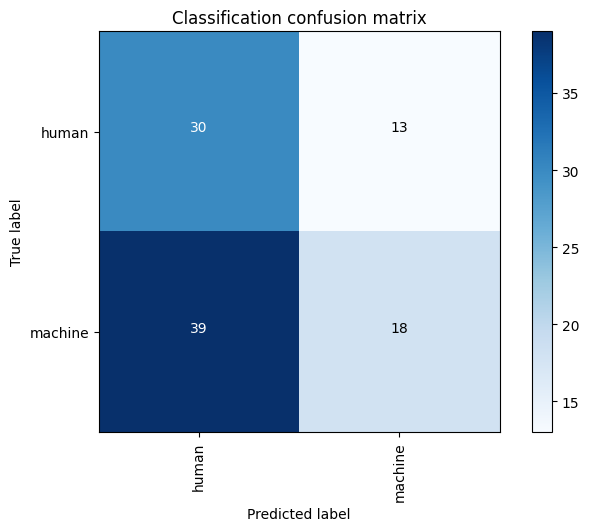

Done!


In [ ]:
# Run inference on dataset v2 (subset)
zsc_labels: list[str] = ["human_generated", "machine_generated"]
zcs_to_labels: dict[str, str] = {
    "human_generated": "human",
    "machine_generated": "machine"
}

TOP_TO_TAKE: int = 100
for dataset in [orig_test_set_df]:
    config = ZeroShotClassificationConfig(
        model_name="MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7",  # huggingface model id
        labels=zsc_labels,
        device="cpu"
    )
    zscpip_runner = ZeroShotClassificationRunner(config)
    inf_items: list[InferenceItem] = [InferenceItem(id=row["id"], text=row["text"]) for _idx, row in
                                      dataset.iterrows()][:TOP_TO_TAKE]
    inf_res: dict[int, InferenceResult] = zscpip_runner.run(items=inf_items)

    # Map back each result according to our mappings
    for v in inf_res.values():
        v.response = zcs_to_labels[v.response]

    # Multi-class performance  ====>
    true_labels: list[int] = [row["label"] for _idx, row in dataset.iterrows()][:TOP_TO_TAKE]
    true_labels_str: list[str] = [iber_au_textification_config.map_to_label_str(l) for l in true_labels]
    pred_labels: list[str] = [r.response for r in inf_res.values()]

    metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels_str, pred_labels=pred_labels)
    print(metrics_calculator.get_classification_report()[0])
    metrics_calculator.plot_confusion_matrix()

    print("Done!")

Just by trying with the first 100 elements of the test set, we can see that the performance is really poor (worse than random guess). The model tends to predict `human_generated` every single time.

Because of this, I don't even think it's worth to run this full inference in GPU. I will move ahead.

### MGT Detection with pre-trained classifiers

There are some pre-trained models in HuggingFace for doing "human vs ai" text classification.

However, none of them seems very popular or promising in my opinion. I leave some of the ones I found for future consideration:
- [priyabrat/AI.or.Human.text.classification](https://huggingface.co/priyabrat/AI.or.Human.text.classification)
- [Tiabet/Tiabet-TFkoGPT-humanvsai](https://huggingface.co/Tiabet/Tiabet-TFkoGPT-humanvsai)
- [Abdelrahman2922/distilbert-base-uncased-Human_vs_Ai_text_detectionv2](https://huggingface.co/Abdelrahman2922/distilbert-base-uncased-Human_vs_Ai_text_detectionv2)
- [drippypale/AI-vs-Human-classification-BERT](https://huggingface.co/drippypale/AI-vs-Human-classification-BERT)
- [Abdelrahman2922/distilbert-base-uncased-Human_vs_Ai_text_detection](https://huggingface.co/Abdelrahman2922/distilbert-base-uncased-Human_vs_Ai_text_detection)
- [harsh4248/ai_vs_human_classification](https://huggingface.co/harsh4248/ai_vs_human_classification)

There is also the [DetectGPT project](https://github.com/eric-mitchell/detect-gpt) in GitHub which could be used also to get a baseline.

In any case, I leave these options as part of the analysis to make sure I've considered them, but decided to go with the approach I feel more promising, which is fine-tuning with the data that we have in multiple languages.


### Setfit Framework

I will use [SetFit](https://github.com/huggingface/setfit) to fine-tune a sentence transformer and add a classification head at the end of the architecture.

With this framework, we can easily perform light fine-tuning on one of Hugging Face's [SentenceTransformers](https://huggingface.co/models?library=sentence-transformers&sort=downloads), adding a classification head tailored to our specific case with the desired set of labels.

I have extensively used this technology at work, and it performs very well even with a small amount of labeled training data. For this case, I will use the available data from the IberAuTextification dataset and then evaluate it on the test set as we have been doing so far.

### Model Selection
For this, we need to investigate sentence transformers that work well for the languages of the dataset and are not excessively large, as otherwise, we won’t have enough hardware resources to fine-tune them.

The [MMTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard) from HuggingFace provides a good starting point to see how different embedding models perform on different languages and tasks.

![MTEB best encoders](../resources/MMTEB_best_encoders.png)

Based on my research, it would be interesting to explore the following models:
- **[sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2)** → Supports 50 languages, maps to a 384-dimensional vector, and has 118M parameters. It's a solid model, but sadly doesn't consider Euskera as part of those 50 languages.
- **[sentence-transformers/distiluse-base-multilingual-cased-v1](https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v1)** -> Supports 14 languages, where only English, Spanish and Portuguese appear from the ones that are relevant in our data. Still a good model, so I will give it a shot.
- **[sentence-transformers/LaBSE](https://huggingface.co/sentence-transformers/LaBSE)** → Supports over 109 languages, maps to a 768-dimensional vector. I have tested it at work for intent classification, and it performs very well. The downside is that it is significantly heavier than the previous two models, so we might not be able to fine-tune it with SetFit. It has a total of 471M parameters. This model covers all of the languages that we have in the dataset.
- **[intfloat/multilingual-e5-large-instruct](https://huggingface.co/intfloat/multilingual-e5-large-instruct)** → We have also used this model at work for training multilingual classifiers and for RAG pipelines, and it has always shown very good performance. As a matter of fact, it's currently top-3 in the MMTEB leaderboard. It maps to a 1024-dimensional vector, supports 94 languages, and has approximately 560M parameters. It supports all of the languages that we have in our dataset.
- **[sentence-transformers/paraphrase-multilingual-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2)** -> A very solid option as well. Trained on more than 50 languages, which include most of the ones that we need (no Galician and Euskera though).

#### [sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2)

**Training in v2**

We'll start doing a quick test with `v2`, of just one epoch, to make sure we can train.

Notice that I'm training only with the first 5k samples. Training with everything filled the entire RAM memory of the regular Google Colab environment.

In [19]:
v2_train_set_file_path: str = os.path.join(dataset_v2_folder, "train.tsv.gzip")
v2_val_set_file_path: str = os.path.join(dataset_v2_folder, "val.tsv.gzip")
v2_test_set_file_path: str = os.path.join(dataset_v2_folder, "test.tsv.gzip")

setfit_train_df: pd.DataFrame = pd.read_csv(v2_train_set_file_path, header=0, sep="\t", compression="gzip")
setfit_val_df: pd.DataFrame = pd.read_csv(v2_val_set_file_path, header=0, sep="\t", compression="gzip")
setfit_test_df: pd.DataFrame = pd.read_csv(v2_test_set_file_path, header=0, sep="\t", compression="gzip")

train_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()][:5000]
val_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()][:500]
test_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=16,
        num_iterations=2,
        num_epochs=1,
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 5000
Number of samples in validation set: 500


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 20000
  Batch size = 16
  Num epochs = 1


Epoch,Training Loss,Validation Loss
1,0.195600,0.202827


***** Running evaluation *****


Finished model training. Took 0:07:30.050517 seconds
Starting evaluation...


Accuracy on validation set: 0.834
Done!


BINARY METRICS ===============================
Starting to do inference over trained model...


Batches:   0%|          | 0/1356 [00:00<?, ?it/s]

Inference done!.
              precision    recall  f1-score   support

       human     0.6752    0.4582    0.5459     19430
     machine     0.6512    0.8211    0.7263     23935

    accuracy                         0.6585     43365
   macro avg     0.6632    0.6396    0.6361     43365
weighted avg     0.6619    0.6585    0.6455     43365



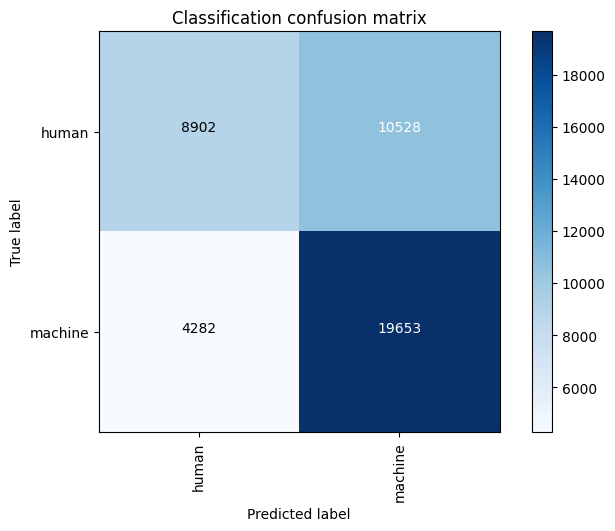

In [27]:
print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

We get a **63.41% macro-f1** by training only with the first 5k samples, which is a really good start!.

Now I need to figure out what to do in order to be able to fit more samples. One thing I can try is to use PyCharm (the IDE I work with) with remote execution to one AWS [g5.4xlarge](https://aws.amazon.com/ec2/instance-types/g5/) instance which has 64GB of RAM and an A10G NVidia GPU (24 GBs of VRAM).

Hopefully, that's enough to fit the entire dataset into memory.

I will repeat the previous test but using more samples (10k in this case).

In [19]:
v2_train_set_file_path: str = os.path.join(dataset_v2_folder, "train.tsv.gzip")
v2_val_set_file_path: str = os.path.join(dataset_v2_folder, "val.tsv.gzip")
v2_test_set_file_path: str = os.path.join(dataset_v2_folder, "test.tsv.gzip")

setfit_train_df: pd.DataFrame = pd.read_csv(v2_train_set_file_path, header=0, sep="\t", compression="gzip")
setfit_val_df: pd.DataFrame = pd.read_csv(v2_val_set_file_path, header=0, sep="\t", compression="gzip")
setfit_test_df: pd.DataFrame = pd.read_csv(v2_test_set_file_path, header=0, sep="\t", compression="gzip")

train_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()][:10000]
val_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()][:1000]
test_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=32,
        num_iterations=1,
        num_epochs=3,
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 10000
Number of samples in validation set: 1000


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Map: 100%|██████████| 10000/10000 [00:00<00:00, 22370.34 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 20000
  Batch size = 32
  Num epochs = 3


Epoch,Training Loss,Validation Loss
1,0.213000,0.194817
2,0.105800,0.160087
3,0.046500,0.162073


***** Running evaluation *****


Finished model training. Took 0:07:13.898618 seconds
Starting evaluation...


Accuracy on validation set: 0.887
Done!


BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:29<00:00, 46.55it/s] 


Inference done!.
              precision    recall  f1-score   support

       human     0.7281    0.4652    0.5677     19430
     machine     0.6643    0.8590    0.7492     23935

    accuracy                         0.6825     43365
   macro avg     0.6962    0.6621    0.6584     43365
weighted avg     0.6929    0.6825    0.6678     43365



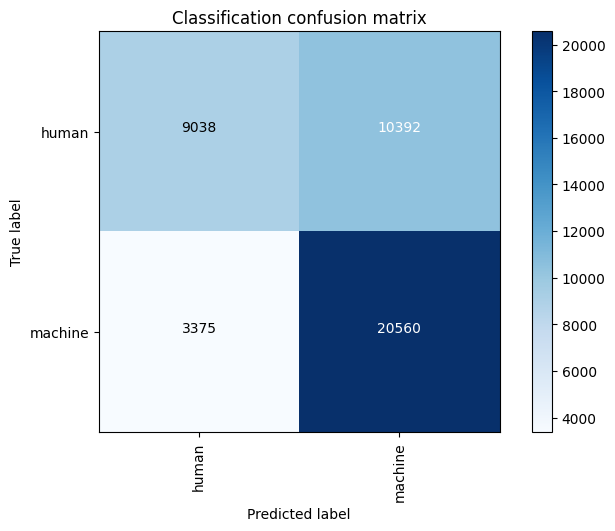

In [20]:
print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

Now we get **65.84% macro-f1**. There's clearly benefit in training with more data.

💔 Sadly, I tried fitting the whole dataset into memory again and 64GB of RAM wasn't enough. This is because SetFit will train using pairs of samples, rather than individual samples themselves. In this case, this is regulated by the `num_iterations` param provided to the `SetfitTrainerConfig`. Setfit doesn't seem to have an option that we can use in order to make sure that the dataset is streamed as an Iterator, meaning that not all of it needs to be loaded into memory ahead of time, but partially loaded what it currently needs.

One alternative I could use, is to try to take the first "N" words from each `text`, in order to see if that reduces the memory footprint, allowing me to train with more data, which is what I want.
In `1_data_exploration` we analyzed the number of tokens (words) that each text had, and plotted some histograms. From those numbers, we can try to estimate some threshold and start considering only the first "N" words for each `text`.

Before doing that, I will simply repeat the [experiment SetFit has in their site](https://github.com/huggingface/setfit?tab=readme-ov-file#usage) to debug what type of dataset is being provided to the trainer.

In [12]:
# Load a dataset from the Hugging Face Hub
dataset = load_dataset("sst2")

# Simulate the few-shot regime by sampling 8 examples per class
train_dataset = sample_dataset(dataset["train"], label_column="label", num_samples=8)
eval_dataset = dataset["validation"].select(range(100))
test_dataset = dataset["validation"].select(range(100, len(dataset["validation"])))

Generating test split: 100%|██████████| 1821/1821 [00:00<00:00, 729914.72 examples/s]


In [13]:
train_dataset

Dataset({
    features: ['idx', 'sentence', 'label'],
    num_rows: 16
})

In [14]:
type(train_dataset)

datasets.arrow_dataset.Dataset

Notice that there's a difference, because they use this dataset which is of type `datasets.arrow_dataset.Dataset`, whereas we just send a list of objects already loaded (we call them `TrainingItem`) and then load a Dataset from those. Maybe that makes us have the data loaded twice. I'll do a quick experiment now with the dataset directly from HuggingFace and see if there's a difference or not.

If there's not, and the memory is still filled, I'll have no option but to reduce the length of the texts and take the first "n" words for each to see if that alliviates the problem.

In [9]:
detection_dataset: Dataset = load_dataset(path="Genaios/iberautextification",
                                          # Focus on the detection data, we will ignore "model attribution" task
                                          name="detection",
                                          trust_remote_code=True)

In [17]:
type(detection_dataset)

datasets.dataset_dict.DatasetDict

In [21]:
type(detection_dataset["train"])

datasets.arrow_dataset.Dataset

In [37]:
# Repeat directly with the setfit example
train_dataset_samples: Dataset = detection_dataset["train"].select(range(5000))
val_dataset_samples = detection_dataset["train"].select(range(1000))
test_dataset = detection_dataset["test"]

# Load a SetFit model from Hub
model_body = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
model_head = LogisticRegression(class_weight=None,
                                max_iter=500)
model = SetFitModel(model_body=model_body,
                    model_head=model_head,
                    labels=iber_au_textification_config.labels)

args = TrainingArguments(
    batch_size=32,
    num_epochs=1,
    num_iterations=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset_samples,
    eval_dataset=val_dataset_samples,
    metric="accuracy",
    column_mapping={"text": "text", "label": "label"}  # Map dataset columns to text/label expected by trainer
)

# Train and evaluate
trainer.train()
metrics = trainer.evaluate(test_dataset)
print(metrics)

Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
***** Running training *****
  Num unique pairs = 10000
  Batch size = 32
  Num epochs = 1


Epoch,Training Loss,Validation Loss
1,0.255300,0.252563


Applying column mapping to the evaluation dataset
***** Running evaluation *****


{'accuracy': 0.5972327914216534}


Based on the memory footprint validation I did on the host machine, this seems to be more efficient and not spend that much memory.

Let's repeat the previous, but with 50k samples for training, which is something that already made it crash. If that works, I will adapt my code in order to let it receive the dataset arrow object instead of the list of elements I was sending.

In [38]:
# Repeat directly with the setfit example
train_dataset_samples: Dataset = detection_dataset["train"].select(range(50000))
val_dataset_samples = detection_dataset["train"].select(range(10000))
test_dataset = detection_dataset["test"]

# Load a SetFit model from Hub
model_body = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
model_head = LogisticRegression(class_weight=None,
                                max_iter=500)
model = SetFitModel(model_body=model_body,
                    model_head=model_head,
                    labels=iber_au_textification_config.labels)

args = TrainingArguments(
    batch_size=32,
    num_epochs=1,
    num_iterations=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset_samples,
    eval_dataset=val_dataset_samples,
    metric="accuracy",
    column_mapping={"text": "text", "label": "label"}  # Map dataset columns to text/label expected by trainer
)

# Train and evaluate
trainer.train()
metrics = trainer.evaluate(test_dataset)
print(metrics)

Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Map: 100%|██████████| 50000/50000 [00:04<00:00, 11931.05 examples/s]

KeyboardInterrupt



Sadly, it broke again.

There's a [GitLab issue](https://github.com/huggingface/setfit/issues/472) opened in their repo like a month ago talking about a similar problem.

I will give it a try to what they mention there and see if that improves the situation or not. They suggest to use `max_steps` which will override the `max_epochs` and will proceed to train using `batch_size`*`max_steps` items. This means:
- For a dataset that has 50k training samples
- We generate 100k samples using `num_iterations=1`
- We have to setup a `max_steps=3125` assuming a `batch_size=32` in order to cover the whole dataset.

Let's try this now and see if we can complete the training with this.

In [14]:
# Repeat directly with the setfit example
train_dataset_samples: Dataset = detection_dataset["train"].select(range(50000))
val_dataset_samples = detection_dataset["train"].select(range(5000))
test_dataset = detection_dataset["test"]

# Load a SetFit model from Hub
model_body = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
model_head = LogisticRegression(class_weight=None,
                                max_iter=500)
model = SetFitModel(model_body=model_body,
                    model_head=model_head,
                    labels=iber_au_textification_config.labels)

args = TrainingArguments(
    batch_size=32,
    num_epochs=1,
    # this is the suggestion in the post ====
    max_steps=3000,
    eval_max_steps=-1,
    # =======================================
    num_iterations=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset_samples,
    eval_dataset=val_dataset_samples,
    metric="accuracy",
    column_mapping={"text": "text", "label": "label"}  # Map dataset columns to text/label expected by trainer
)

# Train and evaluate
trainer.train()
metrics = trainer.evaluate(test_dataset)
print(metrics)

Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
***** Running training *****
  Num unique pairs = 100000
  Batch size = 32
  Num epochs = 1


Epoch,Training Loss,Validation Loss
0,0.086400,0.122131


Applying column mapping to the evaluation dataset
***** Running evaluation *****


{'accuracy': 0.7118874668511472}


Okay, this did it, we could cover the whole training dataset and get a higher accuracy than before.

Let's repeat this but using our class, which didn't seem bad after all. I will simply provide the possibility to parameterize this information and repeat the test but using the "v2" dataset which we built.

In [10]:
v2_train_set_file_path: str = os.path.join(dataset_v2_folder, "train.tsv.gzip")
v2_val_set_file_path: str = os.path.join(dataset_v2_folder, "val.tsv.gzip")
v2_test_set_file_path: str = os.path.join(dataset_v2_folder, "test.tsv.gzip")

setfit_train_df: pd.DataFrame = pd.read_csv(v2_train_set_file_path, header=0, sep="\t", compression="gzip").sample(
    n=50000)
setfit_val_df: pd.DataFrame = pd.read_csv(v2_val_set_file_path, header=0, sep="\t", compression="gzip")
setfit_test_df: pd.DataFrame = pd.read_csv(v2_test_set_file_path, header=0, sep="\t", compression="gzip")

train_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=1,
        max_steps=1563,
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 50000
Number of samples in validation set: 10966


Map: 100%|██████████| 50000/50000 [00:02<00:00, 23110.03 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 100000
  Batch size = 64
  Num epochs = 1


Epoch,Training Loss,Validation Loss
1,0.107200,0.151580


***** Running evaluation *****


Finished model training. Took 0:11:33.954353 seconds
Starting evaluation...
Accuracy on validation set: 0.9035
Done!


BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:28<00:00, 47.10it/s] 


Inference done!.
              precision    recall  f1-score   support

       human     0.7796    0.5450    0.6415     19430
     machine     0.7032    0.8750    0.7797     23935

    accuracy                         0.7271     43365
   macro avg     0.7414    0.7100    0.7106     43365
weighted avg     0.7374    0.7271    0.7178     43365



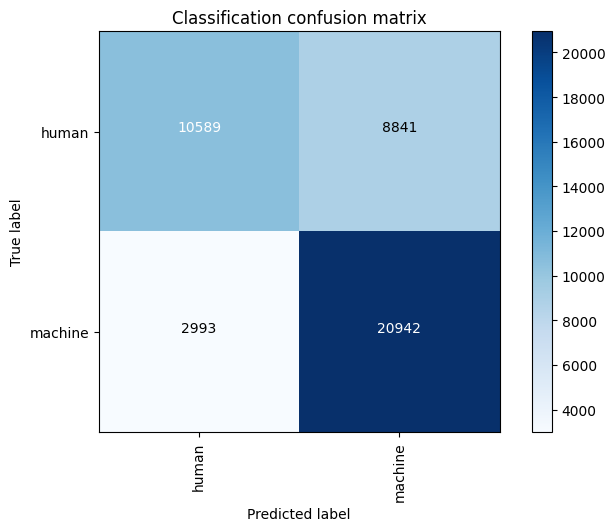

In [11]:
print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

Well, finally a promising result. We get **71.06% macro-f1** on our test set, by training with 50% of the data. Not bad.

This surpasses our best result from `2_ml_baselines` by a bit more than 5 points, which is great news.

I tried training with the whole dataset and I ran out of memory again. Can we train with 70k samples?

In [ ]:
v2_train_set_file_path: str = os.path.join(dataset_v2_folder, "train.tsv.gzip")
v2_val_set_file_path: str = os.path.join(dataset_v2_folder, "val.tsv.gzip")
v2_test_set_file_path: str = os.path.join(dataset_v2_folder, "test.tsv.gzip")

setfit_train_df: pd.DataFrame = pd.read_csv(v2_train_set_file_path, header=0, sep="\t", compression="gzip").sample(
    n=70000)
setfit_val_df: pd.DataFrame = pd.read_csv(v2_val_set_file_path, header=0, sep="\t", compression="gzip")
setfit_test_df: pd.DataFrame = pd.read_csv(v2_test_set_file_path, header=0, sep="\t", compression="gzip")

train_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=1,
        max_steps=2188,
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 70000
Number of samples in validation set: 10966


Map: 100%|██████████| 70000/70000 [00:03<00:00, 22517.22 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


I could not. With 70k I also ran out of memory. What about 60k? My plan is to try to find this sweet spot on the number of samples I can choose. I'm also planning to use a higher number of samples but trimming them down.

In [9]:
v2_train_set_file_path: str = os.path.join(dataset_v2_folder, "train.tsv.gzip")
v2_val_set_file_path: str = os.path.join(dataset_v2_folder, "val.tsv.gzip")
v2_test_set_file_path: str = os.path.join(dataset_v2_folder, "test.tsv.gzip")

setfit_train_df: pd.DataFrame = pd.read_csv(v2_train_set_file_path, header=0, sep="\t", compression="gzip").sample(
    n=60000)
setfit_val_df: pd.DataFrame = pd.read_csv(v2_val_set_file_path, header=0, sep="\t", compression="gzip")
setfit_test_df: pd.DataFrame = pd.read_csv(v2_test_set_file_path, header=0, sep="\t", compression="gzip")

train_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=1,
        max_steps=1875,
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 60000
Number of samples in validation set: 10966


Map: 100%|██████████| 60000/60000 [00:02<00:00, 21967.55 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 120000
  Batch size = 64
  Num epochs = 1


Epoch,Training Loss,Validation Loss
1,0.099800,0.141757


***** Running evaluation *****


Finished model training. Took 0:13:54.828057 seconds
Starting evaluation...
Accuracy on validation set: 0.9076
Done!


BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:28<00:00, 46.84it/s] 


Inference done!.
              precision    recall  f1-score   support

       human     0.7845    0.5314    0.6336     19430
     machine     0.6985    0.8815    0.7794     23935

    accuracy                         0.7246     43365
   macro avg     0.7415    0.7065    0.7065     43365
weighted avg     0.7371    0.7246    0.7141     43365



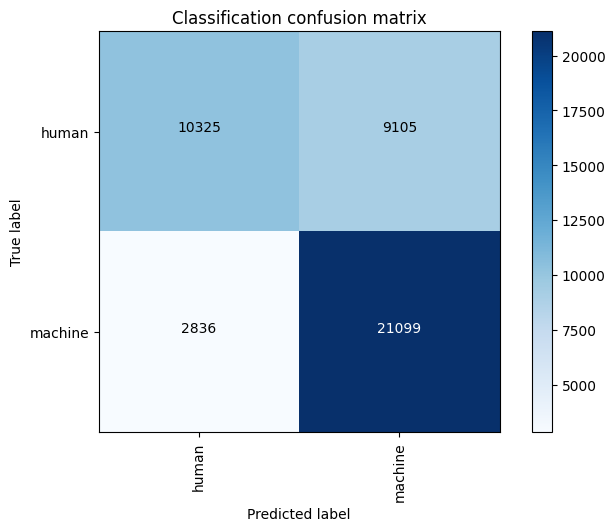

In [10]:
print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

It worked. It seems that with 64GBs of CPU RAM, this is the maximum number of samples (or close to the maximum), that we can fit, without performing any further trimming.

Notice that in this case, we got a lower performance compared to the results obtained when training with less data. This could be due to the sampling applied in one case and the other.

Let's try to standardize this sampling, so that we can re-use it in following scenarios. Ideally, we need to sample in a way so that both "human" and "machine" classes are equally represented, but also we can to try to make sure that languages are represented as well, so that we can learn from the data in different languages and then generalize in the test set.

Before doing this, I will try to answer the following question: can we fit more samples if we start to trim the number of words we have in them in order to reduce the memory footprint? I'll do a quick test.

In [ ]:
# Apply truncation only to train set
setfit_train_df: pd.DataFrame = pd.read_csv(v2_train_set_file_path, header=0, sep="\t", compression="gzip")
setfit_train_df["text"] = setfit_train_df["text"].apply(lambda x: truncate_text(x, 150))

setfit_val_df: pd.DataFrame = pd.read_csv(v2_val_set_file_path, header=0, sep="\t", compression="gzip")
setfit_test_df: pd.DataFrame = pd.read_csv(v2_test_set_file_path, header=0, sep="\t", compression="gzip")

train_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=1,
        max_steps=1875,
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 98697
Number of samples in validation set: 10966


Map: 100%|██████████| 98697/98697 [00:04<00:00, 23989.05 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


I ran out of memory one more time. I don't think this strategy is worth exploring. It's better to try to see how to sample those 60k samples efficiently and then try to train the rest of the models.

Train one more time but using a big number of `max_steps`, so that we can train for multiple epochs

In [9]:
v2_train_set_file_path: str = os.path.join(dataset_v2_folder, "train.tsv.gzip")
v2_val_set_file_path: str = os.path.join(dataset_v2_folder, "val.tsv.gzip")
v2_test_set_file_path: str = os.path.join(dataset_v2_folder, "test.tsv.gzip")

setfit_train_df: pd.DataFrame = pd.read_csv(v2_train_set_file_path, header=0, sep="\t", compression="gzip").sample(
    n=60000)
setfit_val_df: pd.DataFrame = pd.read_csv(v2_val_set_file_path, header=0, sep="\t", compression="gzip")
setfit_test_df: pd.DataFrame = pd.read_csv(v2_test_set_file_path, header=0, sep="\t", compression="gzip")

train_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                 _idx, row in setfit_test_df.iterrows()]

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=3,
        max_steps=5625, # Enough to cover the dataset 3 times
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 60000
Number of samples in validation set: 10966


Map: 100%|██████████| 60000/60000 [00:02<00:00, 22602.59 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 120000
  Batch size = 64
  Num epochs = 3


Epoch,Training Loss,Validation Loss
1,0.080100,0.155750
2,0.041200,0.127415
3,0.026300,0.154729


***** Running evaluation *****


Finished model training. Took 0:32:26.823764 seconds
Starting evaluation...
Accuracy on validation set: 0.922
Done!


BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:28<00:00, 46.84it/s] 


Inference done!.
              precision    recall  f1-score   support

       human     0.7941    0.4817    0.5996     19430
     machine     0.6811    0.8986    0.7749     23935

    accuracy                         0.7118     43365
   macro avg     0.7376    0.6901    0.6872     43365
weighted avg     0.7317    0.7118    0.6964     43365



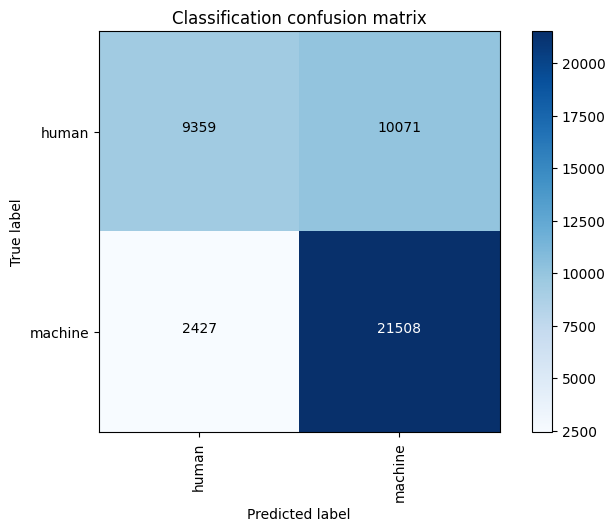

In [10]:
print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

In this case, training for more epochs gives us worse results (also the sampling could be different and that might be the reason).
It's definitely worth to go back to `1_data_exploration` and generate a `v3` variant of the dataset, where we sample the elements in a smarter way to make sure we cover both classes and all languages and domains. We will the use this version to train the rest of the models in this flow.

Notice that at this point I went back into `1_data_exploration` and proceeded to generate the `v3` version of the dataset.

In [10]:
v3_train_set_file_path: str = os.path.join(dataset_v3_folder, "train.tsv.gzip")
v3_val_set_file_path: str = os.path.join(dataset_v3_folder, "val.tsv.gzip")

setfit_train_df: pd.DataFrame = pd.read_csv(v3_train_set_file_path, header=0, sep="\t", compression="gzip")
setfit_val_df: pd.DataFrame = pd.read_csv(v3_val_set_file_path, header=0, sep="\t", compression="gzip")

train_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                 _idx, row in orig_test_df.iterrows()]

In [16]:
config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=1,
        max_steps=1875, # Enough to cover the dataset 1 times
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 60000
Number of samples in validation set: 10000


Map: 100%|██████████| 60000/60000 [00:02<00:00, 23600.03 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 120000
  Batch size = 64
  Num epochs = 1


Epoch,Training Loss,Validation Loss
1,0.114400,0.145782


***** Running evaluation *****


Finished model training. Took 0:14:27.463439 seconds
Starting evaluation...
Accuracy on validation set: 0.9075
Done!


BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:28<00:00, 47.16it/s] 


Inference done!.
              precision    recall  f1-score   support

       human     0.7955    0.4780    0.5972     19430
     machine     0.6800    0.9002    0.7747     23935

    accuracy                         0.7111     43365
   macro avg     0.7377    0.6891    0.6860     43365
weighted avg     0.7317    0.7111    0.6952     43365



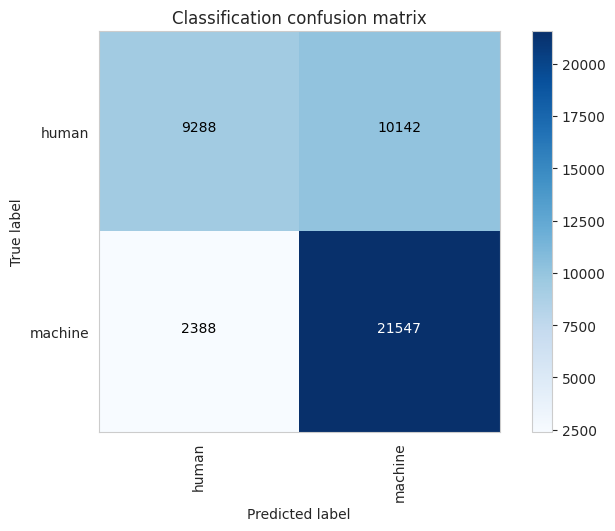

In [17]:
print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

We get a **68.60%** macro F1, a much worse result than the one we obtained when randomly sampling of 71.06% macro-f1.

It's true that now we evaluate on the original test set without a single modification. That might we a reason and also the data and some random initialization conditions.

Let's repeat the same but training for multiple epochs.

In [18]:
config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=3,
        max_steps=5625, # Enough to cover the dataset 3 times
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 60000
Number of samples in validation set: 10000


Map: 100%|██████████| 60000/60000 [00:02<00:00, 23329.58 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 120000
  Batch size = 64
  Num epochs = 3


Epoch,Training Loss,Validation Loss
1,0.101000,0.190366
2,0.045100,0.131229
3,0.024700,0.151485


***** Running evaluation *****


Finished model training. Took 0:31:39.219662 seconds
Starting evaluation...
Accuracy on validation set: 0.925
Done!


BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:28<00:00, 47.70it/s] 


Inference done!.
              precision    recall  f1-score   support

       human     0.8153    0.5156    0.6317     19430
     machine     0.6971    0.9052    0.7876     23935

    accuracy                         0.7306     43365
   macro avg     0.7562    0.7104    0.7097     43365
weighted avg     0.7501    0.7306    0.7178     43365



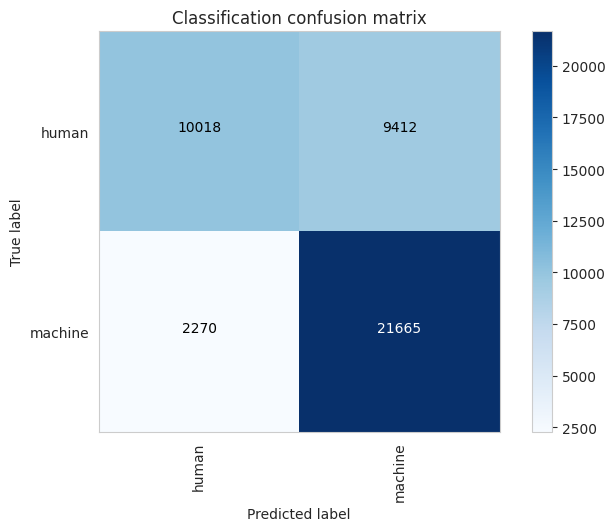

In [19]:
print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

We improve the performance now by training for multiple epochs. We get a **70.97% macro-f1**, which is close to our best result before, but still not better.

Let's train for more epochs and include early stopping.

In [20]:
config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=10,
        max_steps=18750, # Enough to cover the dataset 10 times
        add_early_stopping=True,
        early_stopping_patience=2
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 60000
Number of samples in validation set: 10000


Map: 100%|██████████| 60000/60000 [00:02<00:00, 23278.63 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 120000
  Batch size = 64
  Num epochs = 10


Epoch,Training Loss,Validation Loss
1,0.125800,0.207658
2,0.050900,0.169578
3,0.025100,0.150782
4,0.014800,0.156062
5,0.013600,0.170758


***** Running evaluation *****


Finished model training. Took 0:49:37.330093 seconds
Starting evaluation...
Accuracy on validation set: 0.9264
Done!


BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:28<00:00, 47.42it/s] 


Inference done!.
              precision    recall  f1-score   support

       human     0.8131    0.4854    0.6079     19430
     machine     0.6852    0.9094    0.7816     23935

    accuracy                         0.7194     43365
   macro avg     0.7492    0.6974    0.6947     43365
weighted avg     0.7425    0.7194    0.7037     43365



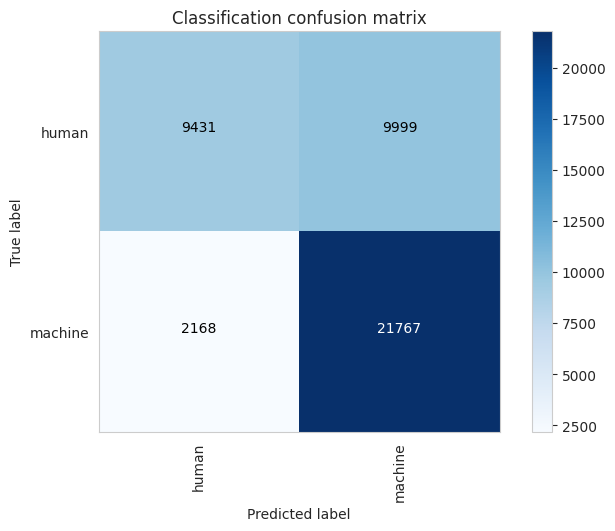

In [21]:
print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

We train for a few epochs and then the validation loss starts getting worse, indicating that the model could start to overfit and lose generalization power.

Let's do a final run training for only two epochs.

In [22]:
config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=2,
        max_steps=3750, # Enough to cover the dataset 2 times
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 60000
Number of samples in validation set: 10000


Map: 100%|██████████| 60000/60000 [00:02<00:00, 23249.52 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 120000
  Batch size = 64
  Num epochs = 2


Epoch,Training Loss,Validation Loss
1,0.096900,0.137520
2,0.054000,0.144825


***** Running evaluation *****


Finished model training. Took 0:22:14.905321 seconds
Starting evaluation...
Accuracy on validation set: 0.9168
Done!


BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:28<00:00, 47.53it/s] 


Inference done!.
              precision    recall  f1-score   support

       human     0.8073    0.4728    0.5963     19430
     machine     0.6797    0.9084    0.7776     23935

    accuracy                         0.7132     43365
   macro avg     0.7435    0.6906    0.6870     43365
weighted avg     0.7369    0.7132    0.6964     43365



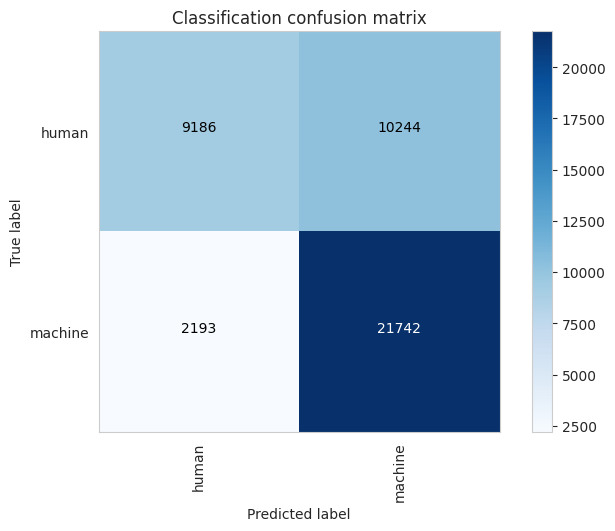

In [23]:
print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

Results are worse than before. At this point, I want to explore other encoders to see if we can surpass our best result so far.

#### [sentence-transformers/distiluse-base-multilingual-cased-v1](https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v1)

I will proceed to explore some of the previous conditions that we did for the previous model. We will only report the best result at the end and move forward with another model.

In [13]:
config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/distiluse-base-multilingual-cased-v1",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=1,
        max_steps=1875, # Enough to cover the dataset 1 times
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 60000
Number of samples in validation set: 10000


Map: 100%|██████████| 60000/60000 [00:02<00:00, 20896.11 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 120000
  Batch size = 64
  Num epochs = 1


Epoch,Training Loss,Validation Loss
1,0.099400,0.149512


***** Running evaluation *****


Finished model training. Took 0:15:48.166725 seconds
Starting evaluation...
Accuracy on validation set: 0.8858
Done!


BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:35<00:00, 38.59it/s] 


Inference done!.
              precision    recall  f1-score   support

       human     0.7118    0.6060    0.6547     19430
     machine     0.7146    0.8008    0.7553     23935

    accuracy                         0.7135     43365
   macro avg     0.7132    0.7034    0.7050     43365
weighted avg     0.7134    0.7135    0.7102     43365



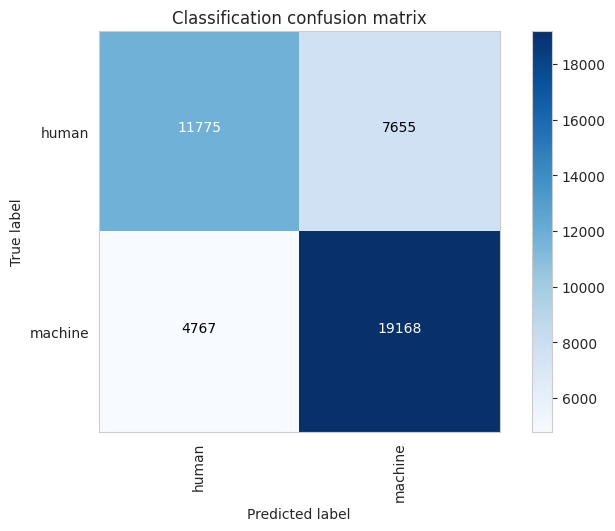

In [14]:
print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

In [15]:
config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/distiluse-base-multilingual-cased-v1",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=3,
        max_steps=5625, # Enough to cover the dataset 3 times
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 60000
Number of samples in validation set: 10000


Map: 100%|██████████| 60000/60000 [00:02<00:00, 21134.72 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 120000
  Batch size = 64
  Num epochs = 3


Epoch,Training Loss,Validation Loss
1,0.085300,0.157145
2,0.025000,0.161484
3,0.014500,0.159738


***** Running evaluation *****


Finished model training. Took 0:38:28.412652 seconds
Starting evaluation...
Accuracy on validation set: 0.8936
Done!


BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:34<00:00, 38.75it/s] 


Inference done!.
              precision    recall  f1-score   support

       human     0.7284    0.5875    0.6504     19430
     machine     0.7106    0.8222    0.7623     23935

    accuracy                         0.7170     43365
   macro avg     0.7195    0.7048    0.7064     43365
weighted avg     0.7186    0.7170    0.7122     43365



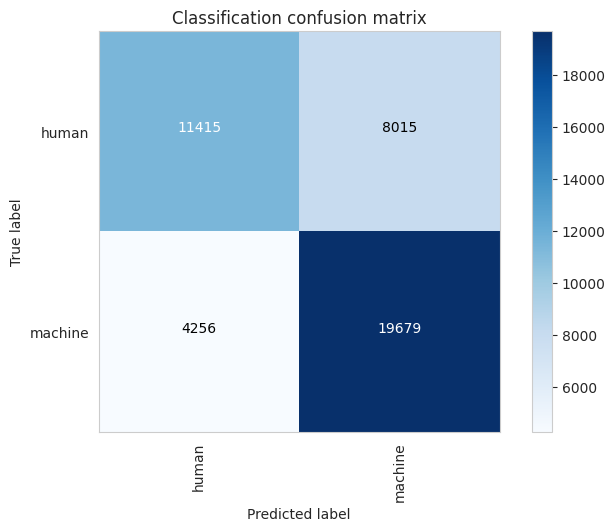

In [16]:
print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

In [17]:
config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/distiluse-base-multilingual-cased-v1",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=10,
        max_steps=18750, # Enough to cover the dataset 10 times
        add_early_stopping=True,
        early_stopping_patience=2
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/distiluse-base-multilingual-cased-v1 loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 60000
Number of samples in validation set: 10000


Map: 100%|██████████| 60000/60000 [00:02<00:00, 22202.51 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 120000
  Batch size = 64
  Num epochs = 10


Epoch,Training Loss,Validation Loss
1,0.123600,0.152417
2,0.034400,0.148354
3,0.020100,0.151286
4,0.009700,0.157279


***** Running evaluation *****


Finished model training. Took 0:49:34.338029 seconds
Starting evaluation...
Accuracy on validation set: 0.8969
Done!


BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:35<00:00, 38.57it/s] 


Inference done!.
              precision    recall  f1-score   support

       human     0.7005    0.6372    0.6673     19430
     machine     0.7256    0.7788    0.7513     23935

    accuracy                         0.7154     43365
   macro avg     0.7130    0.7080    0.7093     43365
weighted avg     0.7144    0.7154    0.7137     43365



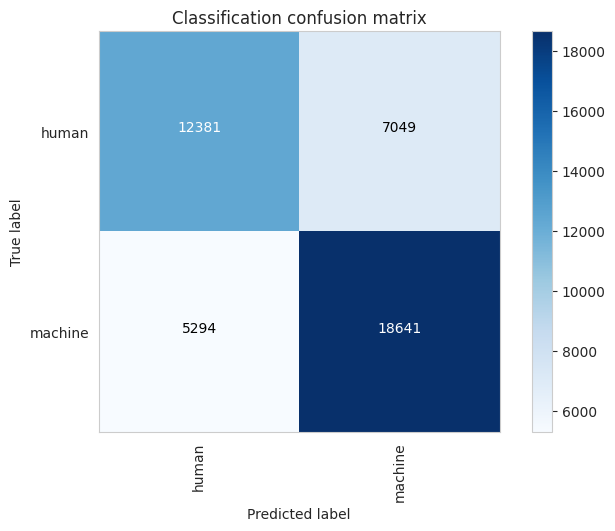

In [18]:
print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

The best performance from this model is **70.93% of macro-f1**, and it happens when we train for four epochs.

It's a bit surprising that this model achieves a very similar performance than the previous model, as that one was better equipped in terms of languages it's been trained with.

#### [sentence-transformers/LaBSE](https://huggingface.co/sentence-transformers/LaBSE)

In [24]:
config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/LaBSE",
        metric="accuracy",
        batch_size=32,
        num_iterations=1,
        num_epochs=1,
        max_steps=3750, # Enough to cover the dataset 1 times
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/LaBSE loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 60000
Number of samples in validation set: 10000


Map: 100%|██████████| 60000/60000 [00:02<00:00, 21714.32 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 120000
  Batch size = 32
  Num epochs = 1


Epoch,Training Loss,Validation Loss
1,0.027900,0.118220


***** Running evaluation *****


Finished model training. Took 0:56:51.406594 seconds
Starting evaluation...
Accuracy on validation set: 0.9586
Done!


BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [01:22<00:00, 16.46it/s]


Inference done!.
              precision    recall  f1-score   support

       human     0.8837    0.3488    0.5002     19430
     machine     0.6456    0.9627    0.7729     23935

    accuracy                         0.6877     43365
   macro avg     0.7646    0.6558    0.6365     43365
weighted avg     0.7523    0.6877    0.6507     43365



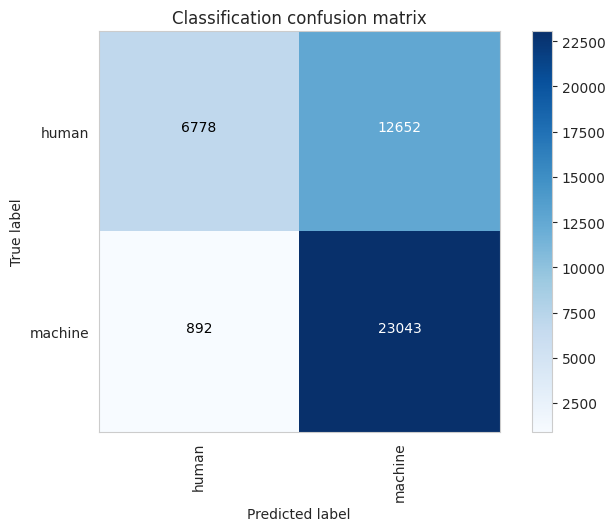

In [25]:
print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

In [26]:
config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/LaBSE",
        metric="accuracy",
        batch_size=32,
        num_iterations=1,
        num_epochs=3,
        max_steps=11250, # Enough to cover the dataset 3 times
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/LaBSE loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 60000
Number of samples in validation set: 10000


Map: 100%|██████████| 60000/60000 [00:02<00:00, 21308.70 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 120000
  Batch size = 32
  Num epochs = 3


Epoch,Training Loss,Validation Loss
1,0.030500,0.091739
2,0.013700,0.132884
3,0.005300,0.106817


***** Running evaluation *****


Finished model training. Took 2:35:47.683174 seconds
Starting evaluation...
Accuracy on validation set: 0.9603
Done!


BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [01:22<00:00, 16.48it/s]


Inference done!.
              precision    recall  f1-score   support

       human     0.8941    0.4437    0.5931     19430
     machine     0.6795    0.9573    0.7948     23935

    accuracy                         0.7272     43365
   macro avg     0.7868    0.7005    0.6940     43365
weighted avg     0.7757    0.7272    0.7045     43365



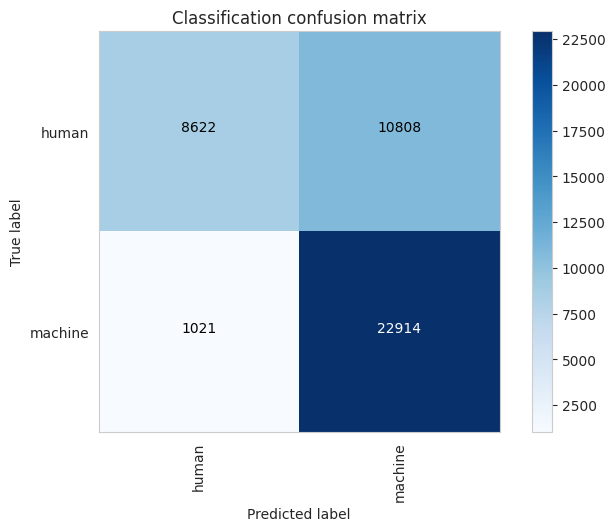

In [27]:
print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

In [28]:
config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/LaBSE",
        metric="accuracy",
        batch_size=32,
        num_iterations=1,
        num_epochs=10,
        max_steps=37500, # Enough to cover the dataset 10 times
        add_early_stopping=True,
        early_stopping_patience=2
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/LaBSE loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 60000
Number of samples in validation set: 10000


Map: 100%|██████████| 60000/60000 [00:02<00:00, 22130.81 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 120000
  Batch size = 32
  Num epochs = 10


Epoch,Training Loss,Validation Loss
1,0.047200,0.110773
2,0.021500,0.087361
3,0.009500,0.086160
4,0.008800,0.130066
5,0.002800,0.101266


***** Running evaluation *****


Finished model training. Took 4:13:47.945573 seconds
Starting evaluation...
Accuracy on validation set: 0.9647
Done!


BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [01:22<00:00, 16.45it/s]


Inference done!.
              precision    recall  f1-score   support

       human     0.9005    0.3858    0.5402     19430
     machine     0.6594    0.9654    0.7836     23935

    accuracy                         0.7057     43365
   macro avg     0.7800    0.6756    0.6619     43365
weighted avg     0.7675    0.7057    0.6746     43365



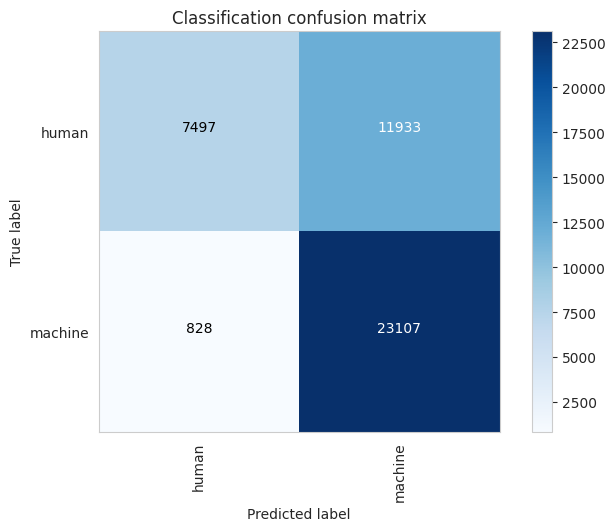

In [29]:
print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

The best result that we obtain with this model is **69.4% macro-f1** when we train for three epochs. Result that in my opinion is very poor for such a big model.

With more time, I could try to optimize the parameters to get a better result. For now, I'll move forward with some extra encoders and finish.

#### [intfloat/multilingual-e5-base](https://huggingface.co/intfloat/multilingual-e5-base)

I tried training with this one because I didn't have enough memory to train the `multilingual-e5-large-instruct`.

In [30]:
config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="intfloat/multilingual-e5-base",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=1,
        max_steps=1875, # Enough to cover the dataset 1 times
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: intfloat/multilingual-e5-base loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 60000
Number of samples in validation set: 10000


Map: 100%|██████████| 60000/60000 [00:02<00:00, 22256.63 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 120000
  Batch size = 64
  Num epochs = 1


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 0 has a total capacity of 21.98 GiB of which 76.44 MiB is free. Including non-PyTorch memory, this process has 21.89 GiB memory in use. Of the allocated memory 21.25 GiB is allocated by PyTorch, and 348.13 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Sadly, I ran out of memory with this model as well, which is a bit surprising, as this model is smaller in terms of hyperparameters than the `LaBSE`. Maybe for some reason is not properly optimized to be fine-tuned with SetFit. We will try now with our latest model and proceed to conclude.

#### [sentence-transformers/paraphrase-multilingual-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2)

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2 loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 60000
Number of samples in validation set: 10000


Map: 100%|██████████| 60000/60000 [00:02<00:00, 23070.00 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 120000
  Batch size = 64
  Num epochs = 1


Epoch,Training Loss,Validation Loss
1,0.065300,0.131055


***** Running evaluation *****


Finished model training. Took 0:26:54.127218 seconds
Starting evaluation...
Accuracy on validation set: 0.9278
Done!
BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [01:01<00:00, 21.90it/s]


Inference done!.
              precision    recall  f1-score   support

       human     0.8150    0.5251    0.6387     19430
     machine     0.7009    0.9032    0.7893     23935

    accuracy                         0.7338     43365
   macro avg     0.7579    0.7142    0.7140     43365
weighted avg     0.7520    0.7338    0.7218     43365



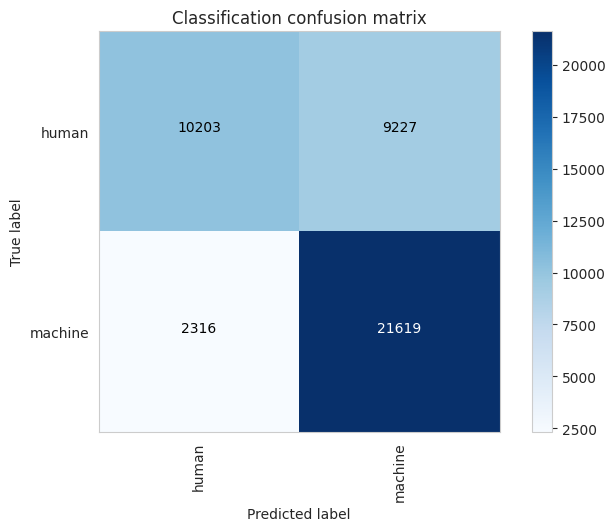

In [13]:
# Test an extra model

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=1,
        max_steps=1875, # Enough to cover the dataset 1 time
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

We manage to get our best result so far, with **71.40% macro-f1**, a really good result for this model.

I could try to run the model for more epochs and see how it performs, but I've decided to spawn a bigger machine and see if I can fit the whole dataset, which I think will be more beneficial at the end of the day. We tried multiple models and none of them could surpass the 71% macro-f1. We could be limited by the fact that we're almost losing half of the training samples due to the memory issue.

### Some final attemps

I decided to invest a bit of extra time in this task and try to surpass a the performance by trying to train with all of the data. In order to do this, I will use a beefier AWS instance ([g5.12xlarge](https://aws.amazon.com/ec2/instance-types/g5/)).

This machine has 4 A10G NVIDIA chips, offering 96GB of VRAM and also way more memory and CPU. CPU memory in our case was the limiting factor before when we were trying to train with all of the dataset and this is loaded there.

In [13]:
!nvidia-smi

Fri Feb 28 20:35:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    Off |   00000000:00:1B.0 Off |                    0 |
|  0%   24C    P0             56W /  300W |       1MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

It also has a lot of CPU RAM, so maybe we can fit all of our dataset now.

In [14]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   48 bits physical, 48 bits virtual
CPU(s):                          48
On-line CPU(s) list:             0-47
Thread(s) per core:              2
Core(s) per socket:              24
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       AuthenticAMD
CPU family:                      23
Model:                           49
Model name:                      AMD EPYC 7R32
Stepping:                        0
CPU MHz:                         2524.963
BogoMIPS:                        5600.00
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       768 KiB
L1i cache:                       768 KiB
L2 cache:                        12 MiB
L3 cache:                        96 MiB
NUMA node0 CPU(s):               0-47
Vulnerability Itlb multih

In [16]:
!cat /proc/meminfo

MemTotal:       195801232 kB
MemFree:        190482728 kB
MemAvailable:   192292820 kB
Buffers:          112136 kB
Cached:          3082052 kB
SwapCached:            0 kB
Active:          2551160 kB
Inactive:        1817204 kB
Active(anon):    1183372 kB
Inactive(anon):      320 kB
Active(file):    1367788 kB
Inactive(file):  1816884 kB
Unevictable:       18468 kB
Mlocked:           18468 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               136 kB
Writeback:             0 kB
AnonPages:       1192548 kB
Mapped:           502284 kB
Shmem:              1272 kB
KReclaimable:     233192 kB
Slab:             572836 kB
SReclaimable:     233192 kB
SUnreclaim:       339644 kB
KernelStack:       10992 kB
PageTables:         8156 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    97900616 kB
Committed_AS:    6485972 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       98072 kB
VmallocChunk:          0 kB
Percpu:       

I will try with the best models so far and see if we can now train with pretty much the whole dataset. I will first start with smaller models to see if we observe some gains or not and then move with bigger ones.

For this, I will build yet another version of the dataset (`v4`), using 90% of the train data for training and 10% for validation. The test of course, will remain the same.

The question now is, will 192GB of CPU RAM be enough to fit this?

In [20]:
v4_train_set_file_path: str = os.path.join(dataset_v4_folder, "train.tsv.gzip")
v4_val_set_file_path: str = os.path.join(dataset_v4_folder, "val.tsv.gzip")

setfit_train_df: pd.DataFrame = pd.read_csv(v4_train_set_file_path, header=0, sep="\t", compression="gzip")
setfit_val_df: pd.DataFrame = pd.read_csv(v4_val_set_file_path, header=0, sep="\t", compression="gzip")

train_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                 _idx, row in orig_test_df.iterrows()]

In [12]:
len(train_data)

98696

#### [sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2)

In [11]:
config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=1,
        max_steps=3085,
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 98696
Number of samples in validation set: 10967


Currently using DataParallel (DP) for multi-gpu training, while DistributedDataParallel (DDP) is recommended for faster training. See https://sbert.net/docs/sentence_transformer/training/distributed.html for more information.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Map: 100%|██████████| 98696/98696 [00:04<00:00, 21131.25 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 197392
  Batch size = 64
  Num epochs = 1


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

Now we manage the fit this bigger version of the training data. However, I stopped the training because if you see, it tries to train for 4 epochs when it should train for only one.

The reason why this happens is because of the warning we get here:

```
Currently using DataParallel (DP) for multi-gpu training, while DistributedDataParallel (DDP) is recommended for faster training. See https://sbert.net/docs/sentence_transformer/training/distributed.html for more information.Currently using DataParallel (DP) for multi-gpu training, while DistributedDataParallel (DDP) is recommended for faster training. See https://sbert.net/docs/sentence_transformer/training/distributed.html for more information.
```

This is because we have multiple GPUs, and DP introduces unnecessary overhead by replicating the model on each GPU in every forward pass. I validated this by seeing that indeed all of the four GPUs in the host were in use, when in reality with one of them we should be okay.

In theory, if we specify which cuda device to use and just give one of the GPUs, this should be enough to make it work. Let's try it.

Go to the beginning of the notebook to see how I had to set an environment variable before importing setfit and sentence-transformers for this to happen.

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 100
Number of samples in validation set: 10


Map: 100%|██████████| 100/100 [00:00<00:00, 12959.78 examples/s]
***** Running training *****
  Num unique pairs = 200
  Batch size = 64
  Num epochs = 1


Trainer successfully loaded!. All ready.
Starting model training...


Epoch,Training Loss,Validation Loss
1,0.376000,0.246495


***** Running evaluation *****


Finished model training. Took 0:00:14.193162 seconds
Starting evaluation...
Accuracy on validation set: 0.5
Done!
BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:29<00:00, 46.37it/s]


Inference done!.
              precision    recall  f1-score   support

       human     0.6010    0.1092    0.1848     19430
     machine     0.5655    0.9411    0.7065     23935

    accuracy                         0.5684     43365
   macro avg     0.5832    0.5252    0.4457     43365
weighted avg     0.5814    0.5684    0.4728     43365



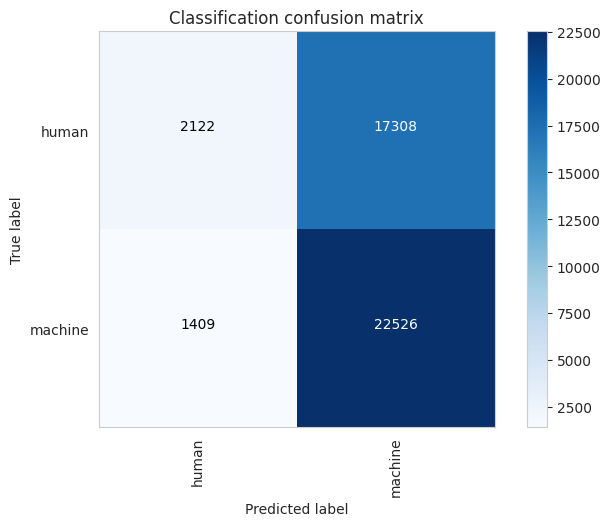

In [13]:
# Very quick test to make sure that "cuda:0" works as device to make only visible the first GPU
config = SetfitTrainerConfig(
    train_data=train_data[:100],
    val_data=val_data[:10],
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=1,
        add_early_stopping=False,
        early_stopping_patience=0,
        device="cuda:0"
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

It worked!. Let's repeat with the whole data now.

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 98696
Number of samples in validation set: 10967


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Map: 100%|██████████| 98696/98696 [00:04<00:00, 22261.67 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 197392
  Batch size = 64
  Num epochs = 1


Epoch,Training Loss,Validation Loss
1,0.076800,0.138463


***** Running evaluation *****


Finished model training. Took 0:23:17.690823 seconds
Starting evaluation...
Accuracy on validation set: 0.9203
Done!
BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:29<00:00, 46.68it/s] 


Inference done!.
              precision    recall  f1-score   support

       human     0.8157    0.4783    0.6030     19430
     machine     0.6830    0.9123    0.7811     23935

    accuracy                         0.7178     43365
   macro avg     0.7493    0.6953    0.6921     43365
weighted avg     0.7425    0.7178    0.7013     43365



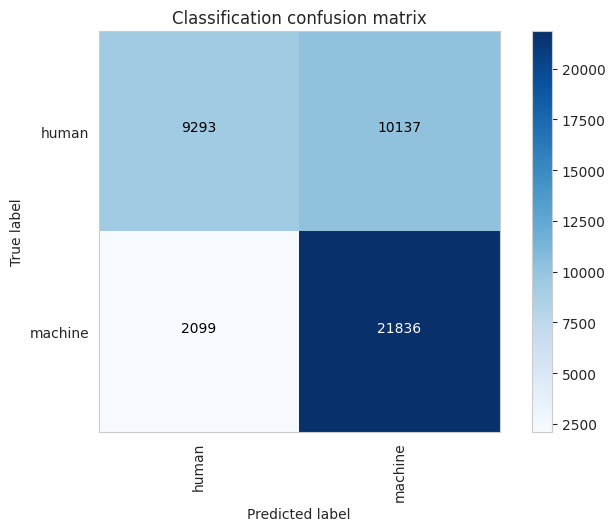

In [14]:
config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=64,
        num_iterations=1,
        num_epochs=1,
        max_steps=3085,
        add_early_stopping=False,
        early_stopping_patience=0,
        device="cuda:0"
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

We trained with more data, however, performance is worse than our best result with this model training with less data. We get **69.21% macro-f1**.

Let's try to train for more epochs now!.

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 98696
Number of samples in validation set: 10967


Map: 100%|██████████| 98696/98696 [00:04<00:00, 21251.29 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 197392
  Batch size = 64
  Num epochs = 3


Epoch,Training Loss,Validation Loss
1,0.067000,0.161185
2,0.035300,0.128054
3,0.019800,0.139101


***** Running evaluation *****


Finished model training. Took 0:53:01.898515 seconds
Starting evaluation...
Accuracy on validation set: 0.9308
Done!
BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:29<00:00, 46.53it/s] 


Inference done!.
              precision    recall  f1-score   support

       human     0.8205    0.4883    0.6122     19430
     machine     0.6874    0.9133    0.7844     23935

    accuracy                         0.7229     43365
   macro avg     0.7539    0.7008    0.6983     43365
weighted avg     0.7470    0.7229    0.7072     43365



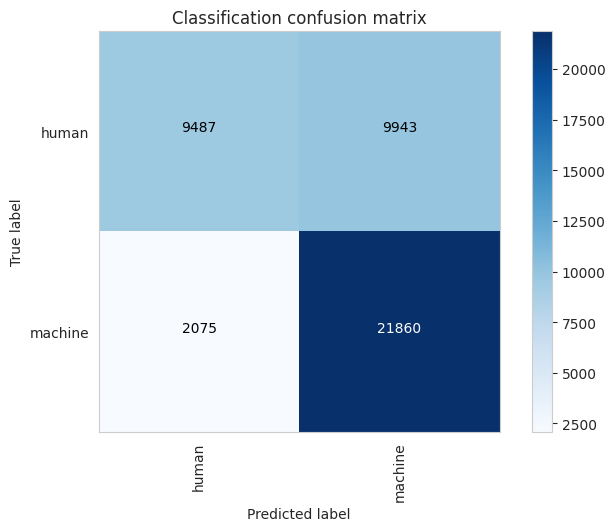

In [26]:
batch_size = 64
num_epochs = 3
num_iterations = 1
max_steps = math.ceil(len(train_data)*(num_iterations+1) / batch_size)*num_epochs

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=batch_size,
        num_iterations=num_iterations,
        num_epochs=num_epochs,
        max_steps=max_steps,
        add_early_stopping=False,
        early_stopping_patience=0,
        device="cuda:0"
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

We get a slightly better performance but still not better than our previous results with the model.

#### [sentence-transformers/paraphrase-multilingual-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2)

Let's do a final run wit the model that has given us the best results so far. We will train it with `v4` and later with the whole dataset as is.

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2 loaded!
Loading datasets...
Number of samples in training set: 98696
Number of samples in validation set: 10967


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Map: 100%|██████████| 98696/98696 [00:04<00:00, 21478.76 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 197392
  Batch size = 64
  Num epochs = 1


Epoch,Training Loss,Validation Loss
1,0.043300,0.132604


***** Running evaluation *****


Finished model training. Took 0:45:23.655021 seconds
Starting evaluation...
Accuracy on validation set: 0.9366
Done!
BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [01:03<00:00, 21.35it/s]


Inference done!.
              precision    recall  f1-score   support

       human     0.8379    0.4517    0.5870     19430
     machine     0.6761    0.9291    0.7826     23935

    accuracy                         0.7152     43365
   macro avg     0.7570    0.6904    0.6848     43365
weighted avg     0.7486    0.7152    0.6950     43365



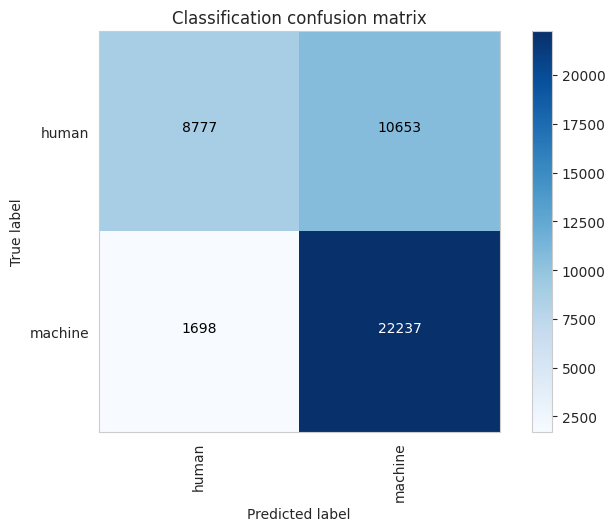

In [12]:
batch_size = 64
num_epochs = 1
num_iterations = 1
max_steps = math.ceil(len(train_data)*(num_iterations+1) / batch_size)*num_epochs

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
        metric="accuracy",
        batch_size=batch_size,
        num_iterations=num_iterations,
        num_epochs=num_epochs,
        max_steps=max_steps,
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

The model performs worse than our previous best results, achieving only a **macro-f1 of 68.48%**.

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2 loaded!
Loading datasets...
Number of samples in training set: 98696
Number of samples in validation set: 10967


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Map: 100%|██████████| 98696/98696 [00:04<00:00, 21992.98 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 197392
  Batch size = 64
  Num epochs = 3


Epoch,Training Loss,Validation Loss
1,0.045900,0.192819
2,0.024800,0.136185
3,0.010400,0.132884


***** Running evaluation *****


Finished model training. Took 1:57:09.252902 seconds
Starting evaluation...
Accuracy on validation set: 0.9391
Done!
BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [01:03<00:00, 21.36it/s]


Inference done!.
              precision    recall  f1-score   support

       human     0.8405    0.4476    0.5841     19430
     machine     0.6749    0.9311    0.7826     23935

    accuracy                         0.7144     43365
   macro avg     0.7577    0.6893    0.6834     43365
weighted avg     0.7491    0.7144    0.6937     43365



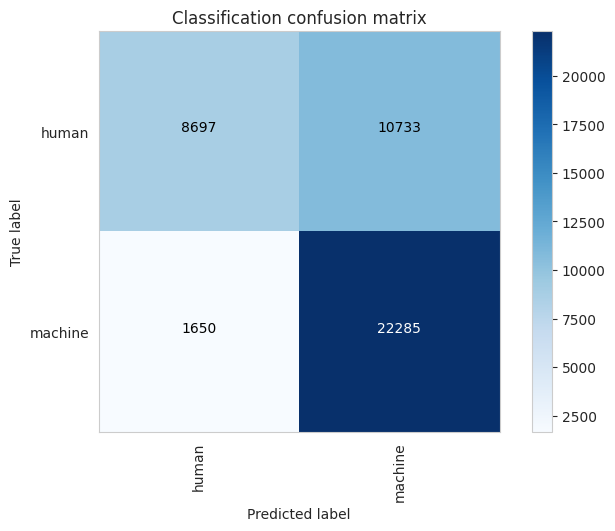

In [13]:
batch_size = 64
num_epochs = 3
num_iterations = 1
max_steps = math.ceil(len(train_data)*(num_iterations+1) / batch_size)*num_epochs

config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
        metric="accuracy",
        batch_size=batch_size,
        num_iterations=num_iterations,
        num_epochs=num_epochs,
        max_steps=max_steps,
        add_early_stopping=False,
        early_stopping_patience=0
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

We train for more epochs, but still, the model doesn't get better in the test set.

Let's do a final run, were we will basically try to fit as much data as possible into the training set. My idea is to train the model for a single epoch, but leaving a few proportion outside for the validation set.

We'll see how it goes.

With 108696 training samples I almost hit 180GB of CPU RAM, so it seems we can expand all up to this point for a final test trying to train with everything.

In [27]:
v4_train_set_file_path: str = os.path.join(dataset_v4_folder, "train.tsv.gzip")
v4_val_set_file_path: str = os.path.join(dataset_v4_folder, "val.tsv.gzip")

setfit_train_df: pd.DataFrame = pd.read_csv(v4_train_set_file_path, header=0, sep="\t", compression="gzip")
setfit_orig_val_df: pd.DataFrame = pd.read_csv(v4_val_set_file_path, header=0, sep="\t", compression="gzip")
setfit_val_for_train_df, setfit_val_df = random_split(setfit_orig_val_df, 10000, 967)

setfit_train_df = pd.concat([setfit_train_df, setfit_val_for_train_df], ignore_index=True)
setfit_train_df = setfit_train_df.sample(frac=1)  # shuffle data inside

train_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                  _idx, row in setfit_train_df.iterrows()]
val_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                _idx, row in setfit_val_df.iterrows()]
test_data: list[TrainingItem] = [TrainingItem(id=row["id"], text=row["text"], label=row["label"]) for
                                 _idx, row in orig_test_df.iterrows()]

SUCCESS: Split dataset into 10000 training samples and 967 validation samples.
No duplicates found between training and validation sets.


In [28]:
len(train_data)

108696

In [29]:
len(val_data)

967

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...
Number of samples in training set: 108696
Number of samples in validation set: 967


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Map: 100%|██████████| 108696/108696 [00:05<00:00, 21521.18 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 217392
  Batch size = 64
  Num epochs = 1


Epoch,Training Loss,Validation Loss
1,0.077900,0.130541


***** Running evaluation *****


Finished model training. Took 0:24:19.978588 seconds
Starting evaluation...
Accuracy on validation set: 0.9286
Done!
BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:29<00:00, 46.28it/s] 


Inference done!.
              precision    recall  f1-score   support

       human     0.8008    0.5109    0.6238     19430
     machine     0.6931    0.8968    0.7819     23935

    accuracy                         0.7239     43365
   macro avg     0.7469    0.7039    0.7029     43365
weighted avg     0.7414    0.7239    0.7111     43365



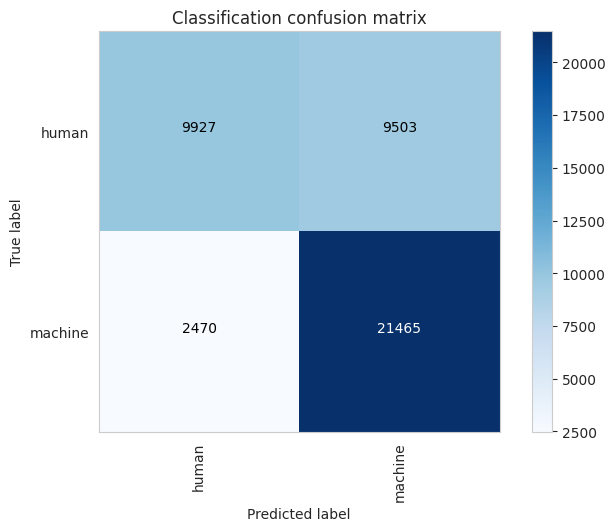

In [30]:
batch_size = 64
num_epochs = 1
num_iterations = 1
max_steps = math.ceil(len(train_data)*(num_iterations+1) / batch_size)*num_epochs


config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=batch_size,
        num_iterations=num_iterations,
        num_epochs=num_epochs,
        max_steps=max_steps,
        add_early_stopping=False,
        early_stopping_patience=0,
        device="cuda:0"
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

We're super close on getting a better performance than before, but still, couldn't surpass it.

The `evaluation_strategy` argument is deprecated and will be removed in a future version. Please use `eval_strategy` instead.


Sentence transformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 loaded!
Loading datasets...


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Number of samples in training set: 108696
Number of samples in validation set: 967


Map: 100%|██████████| 108696/108696 [00:04<00:00, 21899.58 examples/s]


Trainer successfully loaded!. All ready.
Starting model training...


***** Running training *****
  Num unique pairs = 217392
  Batch size = 64
  Num epochs = 3


Epoch,Training Loss,Validation Loss
1,0.076600,0.128448
2,0.027300,0.132954
3,0.015700,0.129260


***** Running evaluation *****


Finished model training. Took 0:55:35.005157 seconds
Starting evaluation...
Accuracy on validation set: 0.9255
Done!
BINARY METRICS ===============================
Starting to do inference over trained model...


Batches: 100%|██████████| 1356/1356 [00:29<00:00, 46.64it/s] 


Inference done!.
              precision    recall  f1-score   support

       human     0.8142    0.4959    0.6164     19430
     machine     0.6894    0.9081    0.7838     23935

    accuracy                         0.7234     43365
   macro avg     0.7518    0.7020    0.7001     43365
weighted avg     0.7453    0.7234    0.7088     43365



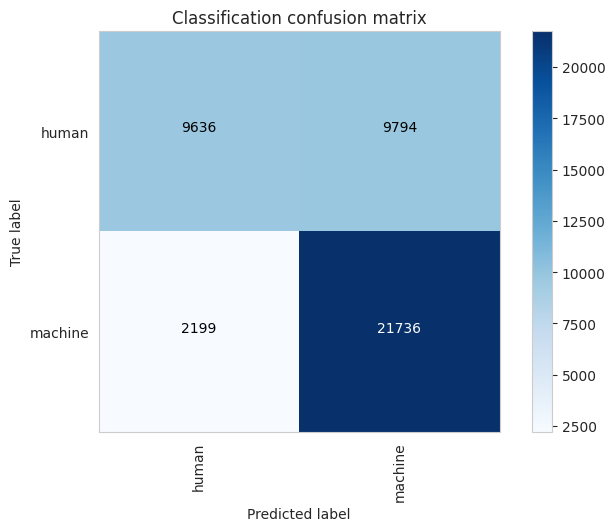

In [31]:
batch_size = 64
num_epochs = 3
num_iterations = 1
max_steps = math.ceil(len(train_data)*(num_iterations+1) / batch_size)*num_epochs


config = SetfitTrainerConfig(
    train_data=train_data,
    val_data=val_data,
    train_config=SetFitTrainingConfig(
        model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        metric="accuracy",
        batch_size=batch_size,
        num_iterations=num_iterations,
        num_epochs=num_epochs,
        max_steps=max_steps,
        add_early_stopping=False,
        early_stopping_patience=0,
        device="cuda:0"
    )
)
runner = SetFitTrainer(config)
runner.train()
runner.eval()
print("Done!")

print("BINARY METRICS ===============================")
true_labels: list[str] = [iber_au_textification_config.map_to_label_str(t.label) for t in test_data]
pred_labels: list[str] = [p.response for p in runner.inference(test_data).values()]
metrics_calculator = ClassifMetricsCalculator(true_labels=true_labels,
                                              pred_labels=pred_labels)
print(metrics_calculator.get_classification_report()[0])
metrics_calculator.plot_confusion_matrix()

Despite our efforts on training with more data, we don't seem to benefit from it. At this point, I've decided to stop. I will put some extra steps and conclusions in the following notebook.

# Conclusions and Results

We conducted several experiments using SetFit-based models with different configurations and dataset versions. The updated results reveal some interesting performance differences, highlighting the impact of model architecture and training configurations.

Some key observations:
- In general, there's a consistent performance accross all models fine-tuned with SetFit. We also didn't notice a big difference when training with the whole dataset versus when training with a good subselection of the dataset. This could be due to the fact tha the test set evaluates on a very different domain, so adding more samples of the different domains in training doesn't make a big difference.
- 🏅 **`paraphrase-multilingual-mpnet-base-v2`**, with an accuracy of 73.38% and a **macro-F1 of 71.40%**, is the best performing model. Notably, it achieves these results with a light training configuration (only 1 epoch and a relatively low `max_steps` value), suggesting a strong balance between model complexity and training efficiency.
- 🥈 **`paraphrase-multilingual-MiniLM-L12-v2`**, with an accuracy of 72.71% and a **macro-F1 of 71.06**, follows closely in second place. Also, a really good and efficient model (only 118M of params).
- While the `LaBSE` model (471M) exhibits a high macro-precision (78.68%), its lower macro-recall (70.05%) results in a slightly lower macro-F1 score (69.4%). This indicates a bias toward precision that might lead to missing some true positive cases—a consideration for applications where recall is critical.
- The results hint that training parameters such as batch size, number of epochs, and max_steps affect performance. Fine-tuning these hyperparameters remains key to optimizing the balance between precision and recall.
- 💡 Compared to some [of the results presented](https://sites.google.com/view/iberautextification/results?authuser=0) in the scoreboard, the performance obtain in this notebook would put us in 6th position, which is not bad, but also not amazing.
- If inference speed in production is a critical factor, `paraphrase-multilingual-MiniLM-L12-v2` would be the best choice. If we can tolerate slightly slower inference, `paraphrase-multilingual-mpnet-base-v2` is, in my opinion, the overall winner for this initial experimentation.

The summary of the best results is shown in the following table:

---

| Notebook | Model                                          | Model Size | Dataset        | Representation                                                                                        | Accuracy | Macro-Precision | Macro-Recall | Macro-F1   | Config highlights                                                                                                       |
|----------|------------------------------------------------|------------|----------------|-------------------------------------------------------------------------------------------------------|----------|-----------------|--------------|------------|-------------------------------------------------------------------------------------------------------------------------|
| 3        | paraphrase-multilingual-MiniLM-L12-v2 Setfit     | 118M       | v2 sampled 50k | Tokenizer<br>Vocab: ~ 250k tokens<br>Max Input: 128 tokens                                             | 0.7271   | 0.7414          | 0.7100       | 0.7106     | (batch_size=64, num_iterations=1, num_epochs=1, max_steps=1563, add_early_stopping=False, early_stopping_patience=0)    |
| 3        | distiluse-base-multilingual-cased-v1 Setfit       | 135M       | v3             | Tokenizer<br>Vocab: ~ 120k tokens<br>Max Input: 128 tokens                                             | 0.7154   | 0.7130          | 0.7080       | 0.7093     | (batch_size=64, num_iterations=1, num_epochs=10, max_steps=18750, add_early_stopping=True, early_stopping_patience=2)     |
| 3        | LaBSE Setfit                                     | 471M       | v3             | Tokenizer<br>Vocab: ~ 501k tokens<br>Max Input: 256 tokens                                             | 0.7272   | 0.7868          | 0.7005       | 0.6940     | (batch_size=32, num_iterations=1, num_epochs=3, max_steps=11250, add_early_stopping=False, early_stopping_patience=0)     |
| 3        | paraphrase-multilingual-mpnet-base-v2             | 278M       | v3             | Tokenizer<br>Vocab: ~ 250k tokens<br>Max Input: 512 tokens                                             | 0.7338   | 0.7579          | 0.7142       | **0.7140** | (batch_size=64, num_iterations=1, num_epochs=1, max_steps=1875, add_early_stopping=False, early_stopping_patience=0)      |

---

Overall, these experiments reinforce that fine-tuning with SetFit is a powerful approach for multilingual text classification. Adjusting training configurations and further exploring dataset preprocessing will likely yield even more refined results in future iterations.


_The results from this notebook, along with others, can be viewed in the following [Google Spreadsheet](https://docs.google.com/spreadsheets/d/1fqPCRuKw_GooVeNqgcmIisXSTyrjyF10MfjwF-KUIyM/edit?gid=0#gid=0). For more information, refer to `4_results_and_conclusions.ipynb`, which also displays and summarizes our practice._

